In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']
KIND_DICT = {'CFFEX沪深300期货':'IF','CFFEX中证500期货':'IC','CFFEX上证50期货':'IH'}
KIND = 'CFFEX沪深300期货'

In [4]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    trade_len = (equity_df.index[-1] - equity_df.index[0]).days
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:KIND})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                   'max_drawdown_start':[max_drawdown_start_str],
                   'max_drawdown_end':[max_drawdown_end_str],
                   'max_drawdown_last_Y':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[KIND]).T
    return output_df, df, df_return_per_year

# 行情数据处理

In [5]:
ChangeData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH_change.xlsx').set_index('date')
PriceData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH.CFE.xlsx').set_index('date')
cPriceData = pd.read_excel('C:/Users/Thinkpad/Desktop/IF_IC_IH.CFEclose.xlsx').set_index('date')
iReturnData = cPriceData/PriceData-1

In [6]:
# 替换收益率 - 主力合约更换
KIND = 'CFFEX沪深300期货'

ReturnDataKIND = PriceData[[KIND]].dropna().pct_change().dropna()
PriceDataKIND = PriceData[[KIND]].dropna()
iReturnDataKIND = iReturnData[[KIND]].dropna()
ChangeDataKIND = ChangeData[[KIND]].dropna()
ChangeDataKIND = ChangeDataKIND.merge(ChangeDataKIND.reset_index().groupby(KIND).last().reset_index().set_index('date'),left_index=True,right_index=True,how='left').rename(columns={KIND+'_y':KIND+'ChangeSig'})[[KIND+'ChangeSig']].fillna(0)

# start = '2010-04-19'
# end = '2019-07-19'
# ReturnDataKIND = ReturnDataKIND[(ReturnDataKIND.index>=start) & (ReturnDataKIND.index<=end)]
# PriceDataKIND = PriceDataKIND[(PriceDataKIND.index>=start) & (PriceDataKIND.index<=end)]
# iReturnDataKIND = iReturnDataKIND[(iReturnDataKIND.index>=start) & (iReturnDataKIND.index<=end)]

ChangeDfKIND = iReturnDataKIND.rename(columns={KIND:KIND+'Change'}).merge(ChangeDataKIND,left_index=True,right_index=True)
ReturnDataKINDChange = ReturnDataKIND.shift(-1).merge(ChangeDfKIND,left_index=True,right_index=True).copy()
ReturnDataKINDChange[KIND] = ReturnDataKINDChange.apply(lambda x: x[KIND+'Change'] if x[KIND+'ChangeSig'] != 0 else x[KIND],axis=1)
ReturnDataKINDChange = ReturnDataKINDChange[[KIND]]

In [7]:
# 主力合约 - 具体合约代码
# MainC_name = ChangeData[[KIND]].dropna().apply(lambda x: x[KIND][:-4],axis=1).to_frame(KIND)
MainContractKIND = ChangeData[[KIND]].dropna()[KIND].apply(lambda x: x[:-4]).to_frame()

In [8]:
# 原期货是否盈利
IfReturnDataKINDChange = ReturnDataKINDChange.copy()
IfReturnDataKINDChange[KIND] = IfReturnDataKINDChange[KIND].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

# 持仓量数据读取

In [9]:
PositionVDf = pd.DataFrame()
for i in range(1,5):
    PositionVDf = pd.concat([PositionVDf,pd.read_excel('C:/Users/Thinkpad/Desktop/四类合约数据_.xlsx',sheet_name='Sheet%d'%(i))])
PositionVDf['月合约代码'] = PositionVDf['月合约代码'].apply(lambda x: x[:-4])
PositionVDf = PositionVDf.rename(columns={'月合约代码':'合约名称'})

In [10]:
PositionVDf_PVT = PositionVDf.pivot_table(index='日期',columns='合约名称',values='持仓量')
PositionVDf_PVT = PositionVDf_PVT - PositionVDf_PVT.shift(1)

In [11]:
PositionVDf_DeltaV = PositionVDf_PVT.unstack().reset_index().rename(columns={0:'持仓量增量'}).merge(PositionVDf,on=['日期','合约名称'])

# 中金所持仓量数据读取

In [12]:
LongShortDelta = {}
KINDList = ['CFFEX沪深300期货','CFFEX中证500期货','CFFEX上证50期货']

nameChangeDict = {'持买单':'多单持仓增量','持卖单':'空单持仓增量','成交':'成交量增量'}
nameChangeDict_ = {'持买单':'多单持仓量','持卖单':'空单持仓量','成交':'成交量'}

for KIND in KINDList:
    LongShortDeltaDf = {}
    for LongOrShortOrV in ['持买单','持卖单','成交']:
        DfDeltaV = pd.read_excel('C:/Users/Thinkpad/Desktop/'+KIND_DICT[KIND]+LongOrShortOrV+'量排名蜘蛛网策略数据更新至20190722.xlsx')
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '华泰期货' if x == '华泰长城' else x)
        DfDeltaV['公司'] = DfDeltaV['公司'].apply(lambda x: '五矿经易' if x == '五矿期货' else x)
        DfDeltaV['日期'] = DfDeltaV['日期'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d'))

        DfDeltaV = DfDeltaV.rename(columns={'变化量':nameChangeDict[LongOrShortOrV],
                                           '量':nameChangeDict_[LongOrShortOrV]})[['日期','公司','合约名称',nameChangeDict[LongOrShortOrV],nameChangeDict_[LongOrShortOrV]]]
        LongShortDeltaDf[LongOrShortOrV] = DfDeltaV
            
    LongShortDelta[KIND] = LongShortDeltaDf
    break

In [13]:
LongShortDeltaDf = LongShortDelta[KIND]

In [14]:
# 每天每个上榜合约持仓量
EachContractV = LongShortDeltaDf['持买单'].groupby(['日期','合约名称']).max().reset_index()[['日期','合约名称']].merge(PositionVDf,on=['日期','合约名称'])

In [15]:
# 每天所有上榜合约持仓量总和
TolContractV = EachContractV.groupby('日期').sum()

# 策略通用数据部分

## 信号原材料数据

In [16]:
LongShortDeltaDf = LongShortDelta[KIND]
LongShortVDf = LongShortDeltaDf['持买单'].merge(LongShortDeltaDf['持卖单'],on=['日期','公司','合约名称']).merge(LongShortDeltaDf['成交'],on=['日期','公司','合约名称'])

LongShortVDf_ = LongShortVDf.copy()
LongShortVDf_CGrp = LongShortVDf_.groupby(['日期','公司']).sum().reset_index()
LongShortVDf_CGrp['dB_dS_sqrtV'] = (LongShortVDf_CGrp['多单持仓增量']-LongShortVDf_CGrp['空单持仓增量'])/np.sqrt(LongShortVDf_CGrp['成交量'])
LongShortVDf_CGrp['dB_dS'] = (LongShortVDf_CGrp['多单持仓增量']-LongShortVDf_CGrp['空单持仓增量'])
LongShortVDf_CGrp['dB_dS_V'] = (LongShortVDf_CGrp['多单持仓增量']-LongShortVDf_CGrp['空单持仓增量'])/LongShortVDf_CGrp['成交量']
# def OutlinerCut(series):
#     med=np.median(series)
#     series_med=np.absolute(series-med)
#     MAD=np.median(series_med)
#     UP = med+3*MAD
#     DOWN = med-3*MAD
#     renew_one = series[-1]
#     if renew_one>UP:
#         return UP
#     if renew_one<DOWN:
#         return DOWN
#     else:
#         return renew_one
# def RollingCompute(df):
#     wind = 252
#     df = df[['dB_dS_sqrtV','日期']].set_index('日期')
#     df_ = df['dB_dS_sqrtV'].rolling(wind).apply(OutlinerCut,raw=True).to_frame('dB_dS_sqrtV_DeOut')
#     df_.iloc[:251,0] = df['dB_dS_sqrtV'].tolist()[:251]
#     return df_
# LongShortVDf_CGrp = LongShortVDf_CGrp.merge(LongShortVDf_CGrp.groupby('公司').apply(RollingCompute).reset_index(),on=['日期','公司'])

## 行情数据转换 -> 得到每周 第一&最后 交易日

In [17]:
OandCpriceData = PriceDataKIND.rename(columns={KIND:KIND+'open'}).merge(cPriceData[[KIND]].rename(columns={KIND:KIND+'close'}),left_index=True,right_index=True)
WeekDateDf = pd.DataFrame(index=OandCpriceData.index,columns=['日期'])
WeekDateDf['日期'] = OandCpriceData.index
WeekDateList = WeekDateDf.apply(lambda x: x.resample('W').last()).dropna()['日期'].tolist()
WeekFirstDateList = WeekDateDf.apply(lambda x: x.resample('W').first()).dropna()['日期'].tolist()

In [18]:
IfFirst = pd.DataFrame({'日期':WeekFirstDateList,'IfFirst':[1 for i in WeekFirstDateList]}).set_index('日期')
IfLast = pd.DataFrame({'日期':WeekDateList,'IfLast':[1 for i in WeekFirstDateList]}).set_index('日期')

# 周度策略1 - sigma剔除

## 周度信号计算、与日度行情拼接

In [601]:
######################## S1:一周，指标的sigma剔除，剩余会员使用蜘蛛网 ########################
dBList = []
dSList = []
dBdSVs0 = []
dateList = []
for WeekCnt in range(1,len(WeekDateList)):
    
    WeekDate = WeekDateList[WeekCnt]
    WeekDate_last = WeekDateList[WeekCnt-1]
    LongShortVDf_CGrp_Week = LongShortVDf_CGrp[(LongShortVDf_CGrp['日期']<=WeekDate) & (LongShortVDf_CGrp['日期']>WeekDate_last)]
    
    sigma = LongShortVDf_CGrp_Week['dB_dS_sqrtV_DeOut'].std()
    miu = LongShortVDf_CGrp_Week['dB_dS_sqrtV_DeOut'].mean()
    LongShortVDf_CGrp_Week_Outer = LongShortVDf_CGrp_Week[(LongShortVDf_CGrp_Week['dB_dS_sqrtV_DeOut']>miu+1*sigma) | (LongShortVDf_CGrp_Week['dB_dS_sqrtV_DeOut']<miu-1*sigma)]
    
    dBList.append(LongShortVDf_CGrp_Week_Outer.sum()['多单持仓增量'])
    dSList.append(LongShortVDf_CGrp_Week_Outer.sum()['空单持仓增量'])
    dateList.append(WeekDate)

dBdSDf_Week = pd.DataFrame({'日期':dateList,'多单持仓增量':dBList,'空单持仓增量':dSList,}).set_index('日期')
dBdSDf_Week['Signal'] = dBdSDf_Week.apply(
    lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0
    else -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0
    else 0,axis=1)

In [591]:
######################## S2:一周，指标的均值 ########################
miuList = []
# dSList = []
dateList = []
threshold = 0.2
for WeekCnt in range(1,len(WeekDateList)):
    
    WeekDate = WeekDateList[WeekCnt]
    WeekDate_last = WeekDateList[WeekCnt-1]
    LongShortVDf_CGrp_Week = LongShortVDf_CGrp[(LongShortVDf_CGrp['日期']<=WeekDate) & (LongShortVDf_CGrp['日期']>WeekDate_last)]
    
    miu = LongShortVDf_CGrp_Week['dB_dS_sqrtV_DeOut'].mean()
    
    miuList.append(miu)
    dateList.append(WeekDate)

dBdSDf_Week = pd.DataFrame({'日期':dateList,'dBdSsqrtVmiu':miuList,}).set_index('日期')
dBdSDf_Week['Signal'] = dBdSDf_Week.apply(lambda x: 1 if x['dBdSsqrtVmiu']>threshold else -1 if x['dBdSsqrtVmiu']<-threshold else 0,axis=1)

In [641]:
######################## S3:一周，指标的sigma剔除，剩余会员使用蜘蛛网，叠加dB-dS大于0余小于0数量比较 ########################
dBList = []
dSList = []
dBdSVs0 = []
dateList = []
indicator = 'dB_dS_sqrtV_DeOut'
for WeekCnt in range(1,len(WeekDateList)):
    
    WeekDate = WeekDateList[WeekCnt]
    WeekDate_last = WeekDateList[WeekCnt-1]
    LongShortVDf_CGrp_Week = LongShortVDf_CGrp[(LongShortVDf_CGrp['日期']<=WeekDate) & (LongShortVDf_CGrp['日期']>WeekDate_last)]
    
    sigma = LongShortVDf_CGrp_Week[indicator].std()
    miu = LongShortVDf_CGrp_Week[indicator].mean()
    LongShortVDf_CGrp_Week_Outer = LongShortVDf_CGrp_Week[(LongShortVDf_CGrp_Week[indicator]>miu+1*sigma) | (LongShortVDf_CGrp_Week[indicator]<miu-1*sigma)]
#     LongShortVDf_CGrp_Week_Outer = LongShortVDf_CGrp_Week[(LongShortVDf_CGrp_Week[indicator]<miu+1*sigma) & (LongShortVDf_CGrp_Week[indicator]>miu-1*sigma)]
    
    dB_dS_bigger0 = LongShortVDf_CGrp_Week['dB_dS'].apply(lambda x: 1 if x>0 else 0).sum()
    dB_dS_smaller0 = LongShortVDf_CGrp_Week['dB_dS'].apply(lambda x: 1 if x<0 else 0).sum()
    dBdSVs0.append(dB_dS_bigger0-dB_dS_smaller0)
    
    dBList.append(LongShortVDf_CGrp_Week_Outer.sum()['多单持仓增量'])
    dSList.append(LongShortVDf_CGrp_Week_Outer.sum()['空单持仓增量'])
    dateList.append(WeekDate)

dBdSDf_Week = pd.DataFrame({'日期':dateList,'多单持仓增量':dBList,'空单持仓增量':dSList,'dBdSVs0':dBdSVs0,}).set_index('日期')
dBdSDf_Week['Signal'] = dBdSDf_Week.apply(
    lambda x: 1 if x['多单持仓增量']>0 and x['空单持仓增量']<0 and x['dBdSVs0'] > 0 
    else -1 if x['多单持仓增量']<0 and x['空单持仓增量']>0  and x['dBdSVs0'] < 0
    else 0,axis=1)

In [642]:
# 信号拼接 - 输入周度信号即可
SignalDF = dBdSDf_Week.copy()
OandCandSignalDf = OandCpriceData.merge(SignalDF,left_index=True,right_index=True,how='left')
OandCandSignalDf['Signal_END'] = OandCandSignalDf['Signal'].shift(1).fillna(method='ffill')
# OandCandSignalDf['Signal_Change'] = (OandCandSignalDf['Signal_END'] - OandCandSignalDf['Signal_END'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
OandCandSignalDf = OandCandSignalDf.merge(IfFirst,left_index=True,right_index=True,how='left').merge(IfLast,left_index=True,right_index=True,how='left').copy()

## 策略回测

In [643]:
########### 储存各类信息 ###########
dateList = OandCandSignalDf.index.tolist()
opriceList = OandCandSignalDf[KIND+'open'].tolist()
cpriceList = OandCandSignalDf[KIND+'close'].tolist()
Signal_ENDList = OandCandSignalDf['Signal_END'].tolist()
IfFirstList = OandCandSignalDf['IfFirst'].tolist()
IfLastList = OandCandSignalDf['IfLast'].tolist()
############ 初始化状态 ###########
equity = 1
Nshare = 0
L = 0
equityList = []
MainContractCode = 0
############ 循环执行策略 ###########
for dateCnt in range(len(dateList)):
    ## 更新每日信息
    date = dateList[dateCnt]
    date_last = dateList[dateCnt-1]
    cprice = cpriceList[dateCnt]
    oprice = opriceList[dateCnt]
    last_cprice = cpriceList[dateCnt-1]
    Signal_END = Signal_ENDList[dateCnt]
    ifFirst = IfFirstList[dateCnt]
    ifLast = IfLastList[dateCnt]
    
    ## 当日信号为 缺失值
    if np.isnan(Signal_END):
        equityList.append(equity)
        continue
    
    ## 判断是否为周内首日
    if ifFirst == 1:
        MainContractCode = MainContractKIND.loc[date,][0]
        TodayContract = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()
        MainCopen = TodayContract['开盘价'].tolist()[0]
        MainCclose = TodayContract['收盘价'].tolist()[0]
        L = Signal_END
        Nshare = equity/MainCopen
        dequity = Nshare*(MainCclose-MainCopen)*L
    else:
        if L == 0:
            dequity = 0
        else:
            MainCclose = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()['收盘价'].tolist()[0]
            MainCclose_last = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date_last)].copy()['收盘价'].tolist()[0]
            dequity = Nshare*(MainCclose-MainCclose_last)*L
    ## 判断是否为周内最后日
    if ifLast == 1:
        ## 清仓
        N = 0
        L = 0
    ## 输出今日净值
    equity += dequity
    equityList.append(equity)

equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}).set_index('日期')
# CloseDataForKIND_withResult = CloseDataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}),on=['日期'])

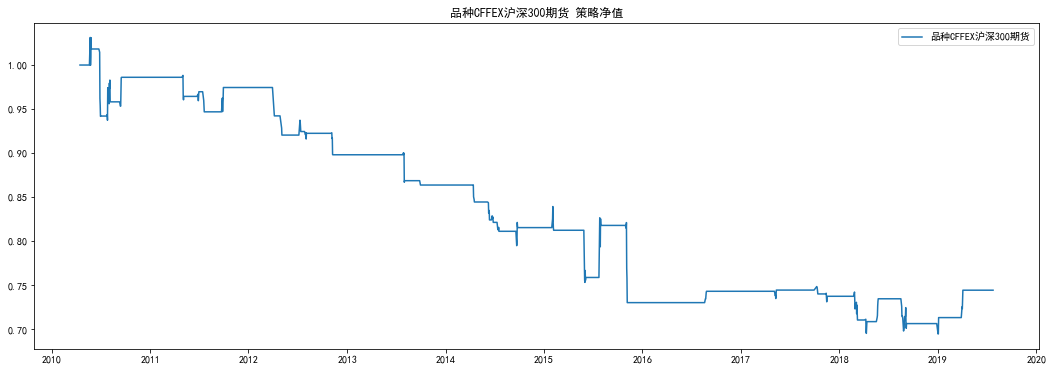

胜率0.3500
信号周度频率0.0840
信号IR-1.8025
                               CFFEX沪深300期货
mean_return                      -0.0313055
vol_return                        0.0716294
IR                                -0.437048
sharpe_ratio                      -0.855871
max_drawdown                       0.326166
mean_return_max_drawdown_ratio   -0.0959801
max_drawdown_start               2010-05-24
max_drawdown_end                 2019-01-02
max_drawdown_last_Y                 8.61054


In [644]:
############ 结果输出 ###########
# 图像
plt.figure(figsize=(18,6))
plt.plot(equityDf_KIND,label='品种%s'%(KIND))
plt.title('品种%s'%(KIND)+' 策略净值')
plt.legend(loc=0)
plt.show()

# 胜率+频率+信号IR
## 胜率+频率
WinAndFreq = pd.DataFrame(WeekDateList,columns=['日期']).merge(equityDf_KIND,left_on='日期',right_index=True).merge(OandCandSignalDf[['Signal_END']],left_on='日期',right_index=True)
WinAndFreq[KIND+'pct_If'] = WinAndFreq[KIND].pct_change().apply(lambda x:1 if x>0 else 0 if x<=0 else x)
WinAndFreq_sub = WinAndFreq[WinAndFreq['Signal_END'] != 0]
WinProb = WinAndFreq_sub[KIND+'pct_If'].sum()/len(WinAndFreq_sub)
SigFreq = len(WinAndFreq_sub)/len(WinAndFreq)
## 信号IR
Signal_IR = OandCandSignalDf.merge(equityDf_KIND,left_index=True,right_index=True,)
Signal_IR = Signal_IR[(Signal_IR['Signal_END'] ==1) | (Signal_IR['Signal_END'] ==-1)][[KIND]].copy()
miu_Y = Signal_IR[KIND].tolist()[-1]**(365.25/len(Signal_IR))-1
std_Y = Signal_IR[KIND].pct_change().std()*252**0.5
Signal_IR_Value = miu_Y/std_Y
print('胜率%.4f\n信号周度频率%.4f\n信号IR%.4f'%(WinProb,SigFreq,Signal_IR_Value))

# 原始指标
print(Indicator(equityDf_KIND)[0])

# 周度策略2 - 周度beta

## 周度信号计算

In [166]:
def RegressionToGetBeta(df):
    df = df.copy()
    col = df.columns[-1]
    df = df[df[col] != 0].copy()
    x_axis = [np.log(i) for i in list(range(1,len(df)+1))]
    x_axis = sm.add_constant(x_axis)
    y_axis = (df[col]/df[col].sum()).to_frame().sort_values(col,ascending=False)[col].tolist()
    if 0 in y_axis:
        print(y_axis)
        print(df['日期'])
    params = -sm.OLS(np.log(y_axis),x_axis).fit().params[1]
    return pd.DataFrame([params],index=[df['日期'].tolist()[0]],columns=[col+'beta'])

In [448]:
LongBeta = LongShortDelta[KIND]['持买单'].groupby(['日期','公司']).sum().reset_index().groupby(['日期']).apply(RegressionToGetBeta)
ShortBeta = LongShortDelta[KIND]['持卖单'].groupby(['日期','公司']).sum().reset_index().groupby(['日期']).apply(RegressionToGetBeta)

In [449]:
LongBeta.index = LongBeta.index.droplevel(0)
ShortBeta.index = ShortBeta.index.droplevel(0)

In [450]:
LongShortBeta = pd.concat([LongBeta,ShortBeta],axis=1)

In [451]:
longbetaList_ = []
shortbetaList_ = []
dateList_ = []
for WeekCnt in range(1,len(WeekDateList)):
    
    WeekDate = WeekDateList[WeekCnt]
    WeekDate_last = WeekDateList[WeekCnt-1]
    LongShortBeta_Week = LongShortBeta[(LongShortBeta.index<=WeekDate) & (LongShortBeta.index>WeekDate_last)]
    
    longbeta = LongShortBeta_Week['多单持仓量beta'].mean()
    shortbeta = LongShortBeta_Week['空单持仓量beta'].mean()
    
    longbetaList_.append(longbeta)
    shortbetaList_.append(shortbeta)
    dateList_.append(WeekDate)

In [452]:
dBdSDf_Week = pd.DataFrame({'日期':dateList_,'多单beta':longbetaList_,'空单beta':shortbetaList_,}).set_index('日期')
dBdSDf_Week_pct = (dBdSDf_Week - dBdSDf_Week.rolling(5).mean()).copy()
dBdSDf_Week_pct['Signal'] = dBdSDf_Week_pct.apply(lambda x: 1 if x['多单beta']>0 and x['空单beta']<0 else -1 if x['多单beta']<0 and x['空单beta']>0 else 0,axis=1)

In [453]:
SignalDF = dBdSDf_Week_pct.copy()
OandCandSignalDf = OandCpriceData.merge(SignalDF,left_index=True,right_index=True,how='left')
OandCandSignalDf['Signal_END'] = OandCandSignalDf['Signal'].shift(1).fillna(method='ffill')
# OandCandSignalDf['Signal_Change'] = (OandCandSignalDf['Signal_END'] - OandCandSignalDf['Signal_END'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
OandCandSignalDf = OandCandSignalDf.merge(IfFirst,left_index=True,right_index=True,how='left').merge(IfLast,left_index=True,right_index=True,how='left').copy()

## 策略回测

In [454]:
########### 储存各类信息 ###########
dateList = OandCandSignalDf.index.tolist()
opriceList = OandCandSignalDf[KIND+'open'].tolist()
cpriceList = OandCandSignalDf[KIND+'close'].tolist()
Signal_ENDList = OandCandSignalDf['Signal_END'].tolist()
IfFirstList = OandCandSignalDf['IfFirst'].tolist()
IfLastList = OandCandSignalDf['IfLast'].tolist()
############ 初始化状态 ###########
equity = 1
Nshare = 0
L = 0
equityList = []
MainContractCode = 0
############ 循环执行策略 ###########
for dateCnt in range(len(dateList)):
    ## 更新每日信息
    date = dateList[dateCnt]
    date_last = dateList[dateCnt-1]
    cprice = cpriceList[dateCnt]
    oprice = opriceList[dateCnt]
    last_cprice = cpriceList[dateCnt-1]
    Signal_END = Signal_ENDList[dateCnt]
    ifFirst = IfFirstList[dateCnt]
    ifLast = IfLastList[dateCnt]
    
    ## 当日信号为 缺失值
    if np.isnan(Signal_END):
        equityList.append(equity)
        continue
    
    ## 判断是否为周内首日
    if ifFirst == 1:
        MainContractCode = MainContractKIND.loc[date,][0]
        TodayContract = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()
        MainCopen = TodayContract['开盘价'].tolist()[0]
        MainCclose = TodayContract['收盘价'].tolist()[0]
        L = Signal_END
        Nshare = equity/MainCopen
        dequity = Nshare*(MainCclose-MainCopen)*L
    else:
        if L == 0:
            dequity = 0
        else:
            MainCclose = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()['收盘价'].tolist()[0]
            MainCclose_last = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date_last)].copy()['收盘价'].tolist()[0]
            dequity = Nshare*(MainCclose-MainCclose_last)*L
    ## 判断是否为周内最后日
    if ifLast == 1:
        ## 清仓
        N = 0
        L = 0
    ## 输出今日净值
    equity += dequity
    equityList.append(equity)

equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}).set_index('日期')
# CloseDataForKIND_withResult = CloseDataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}),on=['日期'])

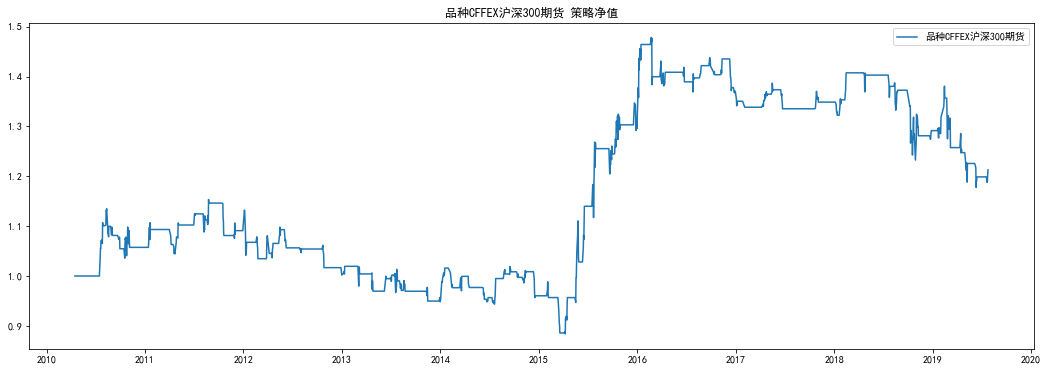

胜率 0.4915
信号周度频率 0.2489
信号IR 0.5237
                               CFFEX沪深300期货
mean_return                       0.0210376
vol_return                         0.128513
IR                                   0.1637
sharpe_ratio                      -0.069739
max_drawdown                       0.233939
mean_return_max_drawdown_ratio    0.0899279
max_drawdown_start               2011-08-25
max_drawdown_end                 2015-04-09
max_drawdown_last_Y                 3.62218


In [455]:
############ 结果输出 ###########
# 图像
plt.figure(figsize=(18,6))
plt.plot(equityDf_KIND,label='品种%s'%(KIND))
plt.title('品种%s'%(KIND)+' 策略净值')
plt.legend(loc=0)
plt.show()

# 胜率+频率+信号IR
## 胜率+频率
WinAndFreq = pd.DataFrame(WeekDateList,columns=['日期']).merge(equityDf_KIND,left_on='日期',right_index=True).merge(OandCandSignalDf[['Signal_END']],left_on='日期',right_index=True).dropna()
WinAndFreq[KIND+'pct_If'] = WinAndFreq[KIND].pct_change().apply(lambda x:1 if x>0 else 0)
WinAndFreq_sub = WinAndFreq[WinAndFreq['Signal_END'] != 0]
WinProb = WinAndFreq_sub[KIND+'pct_If'].sum()/len(WinAndFreq_sub)
SigFreq = len(WinAndFreq_sub)/len(WinAndFreq)
## 信号IR
Signal_IR = OandCandSignalDf.merge(equityDf_KIND,left_index=True,right_index=True,)
Signal_IR = Signal_IR[(Signal_IR['Signal_END'] ==1) | (Signal_IR['Signal_END'] ==-1)][[KIND]].copy()
miu_Y = Signal_IR[KIND].tolist()[-1]**(365.25/len(Signal_IR))-1
std_Y = Signal_IR[KIND].pct_change().std()*252**0.5
Signal_IR_Value = miu_Y/std_Y
print('胜率 %.4f\n信号周度频率 %.4f\n信号IR %.4f'%(WinProb,SigFreq,Signal_IR_Value))

# 原始指标
print(Indicator(equityDf_KIND)[0])

## 策略回测 - 循环调参

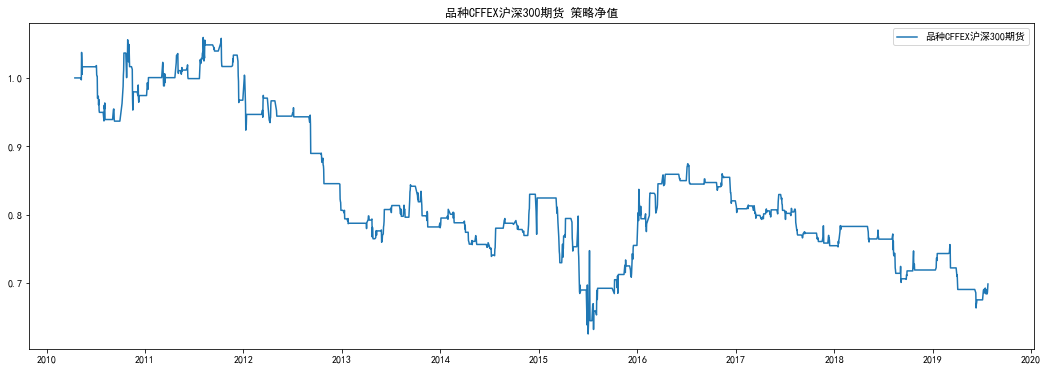

胜率 0.4380
信号周度频率 0.2890
信号IR -0.7087
窗口2
                               CFFEX沪深300期货
mean_return                      -0.0378815
vol_return                         0.138631
IR                                -0.273253
sharpe_ratio                      -0.489654
max_drawdown                       0.408926
mean_return_max_drawdown_ratio   -0.0926364
max_drawdown_start               2011-08-05
max_drawdown_end                 2015-07-03
max_drawdown_last_Y                 3.90965


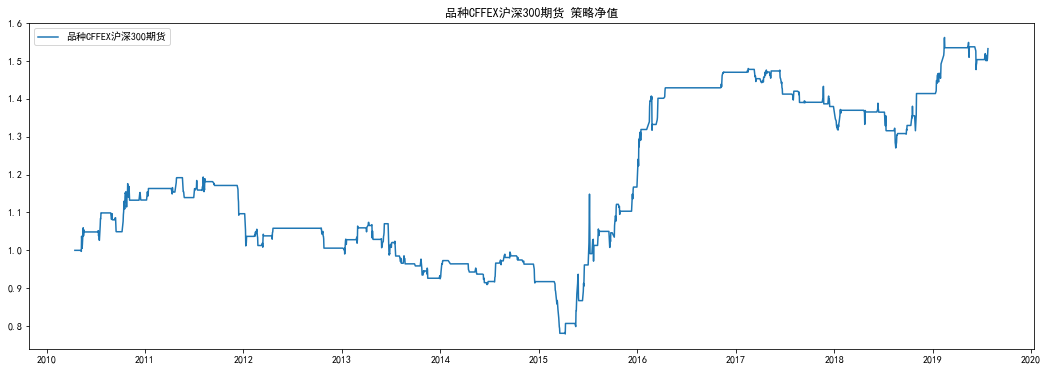

胜率 0.5517
信号周度频率 0.2447
信号IR 1.2733
窗口3
                               CFFEX沪深300期货
mean_return                       0.0471249
vol_return                         0.125792
IR                                 0.374625
sharpe_ratio                       0.136137
max_drawdown                       0.347321
mean_return_max_drawdown_ratio     0.135681
max_drawdown_start               2011-08-05
max_drawdown_end                 2015-04-09
max_drawdown_last_Y                 3.67693


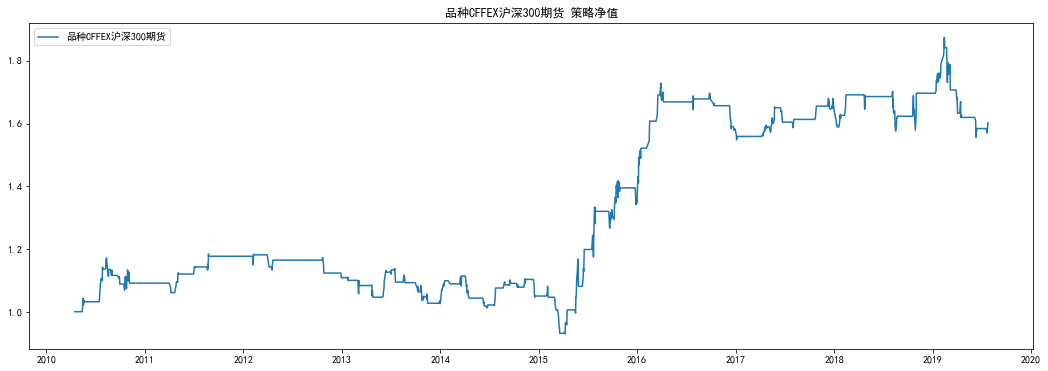

胜率 0.5421
信号周度频率 0.2257
信号IR 1.6102
窗口4
                               CFFEX沪深300期货
mean_return                       0.0521816
vol_return                         0.120935
IR                                 0.431484
sharpe_ratio                       0.183417
max_drawdown                        0.21549
mean_return_max_drawdown_ratio     0.242154
max_drawdown_start               2011-08-25
max_drawdown_end                 2015-04-09
max_drawdown_last_Y                 3.62218


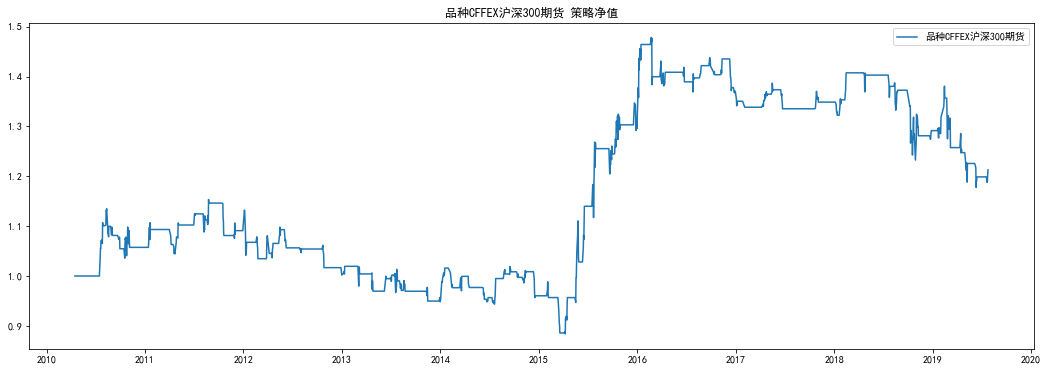

胜率 0.4915
信号周度频率 0.2489
信号IR 0.5237
窗口5
                               CFFEX沪深300期货
mean_return                       0.0210376
vol_return                         0.128513
IR                                   0.1637
sharpe_ratio                      -0.069739
max_drawdown                       0.233939
mean_return_max_drawdown_ratio    0.0899279
max_drawdown_start               2011-08-25
max_drawdown_end                 2015-04-09
max_drawdown_last_Y                 3.62218


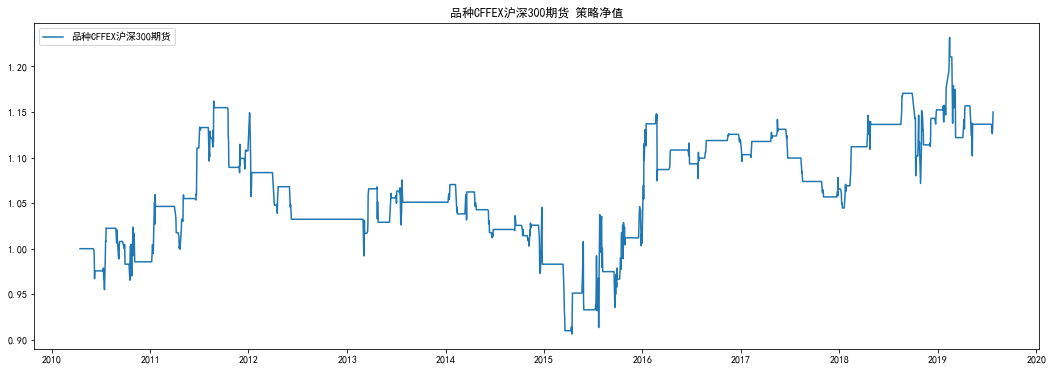

胜率 0.5567
信号周度频率 0.2046
信号IR 0.4249
窗口6
                               CFFEX沪深300期货
mean_return                       0.0151873
vol_return                         0.123661
IR                                 0.122814
sharpe_ratio                      -0.119785
max_drawdown                       0.220017
mean_return_max_drawdown_ratio    0.0690278
max_drawdown_start               2011-08-25
max_drawdown_end                 2015-04-15
max_drawdown_last_Y                  3.6386


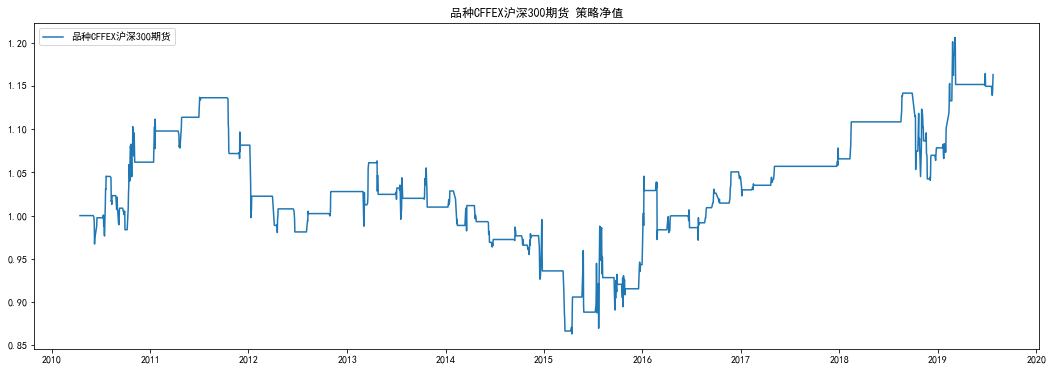

胜率 0.5506
信号周度频率 0.1878
信号IR 0.5147
窗口7
                               CFFEX沪深300期货
mean_return                       0.0164186
vol_return                         0.116688
IR                                 0.140705
sharpe_ratio                      -0.116391
max_drawdown                       0.240725
mean_return_max_drawdown_ratio    0.0682048
max_drawdown_start               2011-07-04
max_drawdown_end                 2015-04-15
max_drawdown_last_Y                 3.78097


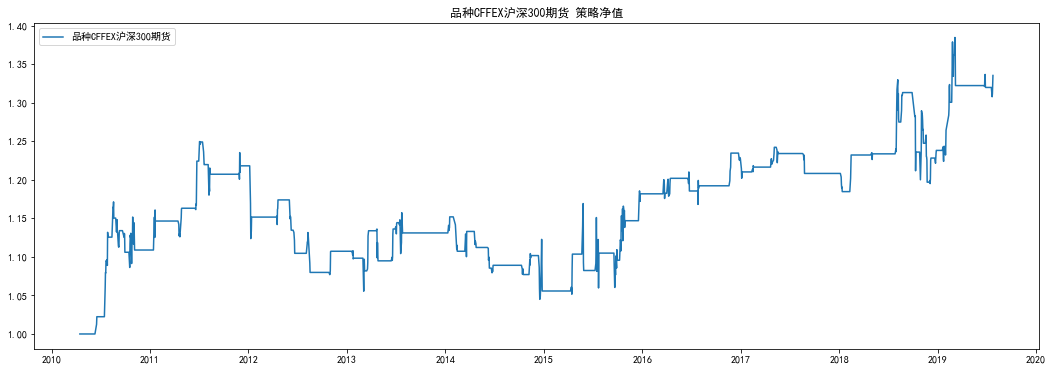

胜率 0.5581
信号周度频率 0.1814
信号IR 1.1989
窗口8
                               CFFEX沪深300期货
mean_return                       0.0316816
vol_return                         0.104331
IR                                 0.303665
sharpe_ratio                      0.0161184
max_drawdown                       0.163808
mean_return_max_drawdown_ratio     0.193408
max_drawdown_start               2011-07-04
max_drawdown_end                 2014-12-17
max_drawdown_last_Y                 3.45517


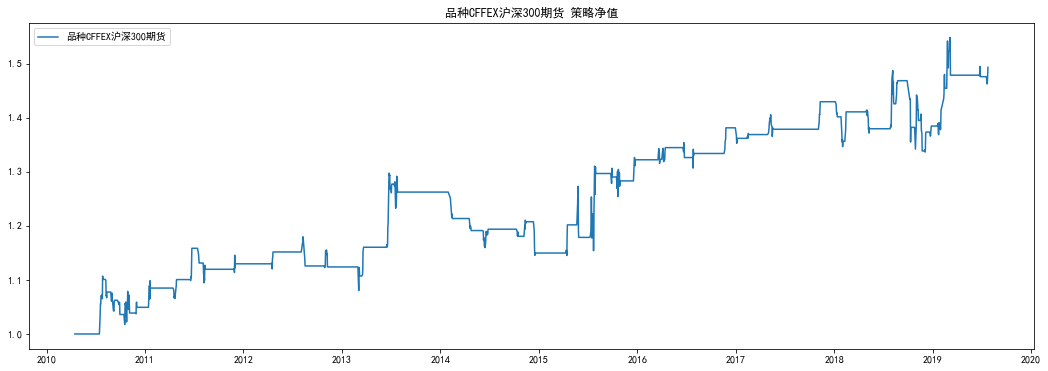

胜率 0.5625
信号周度频率 0.1688
信号IR 1.8363
窗口9
                               CFFEX沪深300期货
mean_return                       0.0441921
vol_return                         0.104854
IR                                 0.421462
sharpe_ratio                       0.135351
max_drawdown                       0.117406
mean_return_max_drawdown_ratio     0.376404
max_drawdown_start               2013-06-25
max_drawdown_end                 2015-04-15
max_drawdown_last_Y                 1.80424


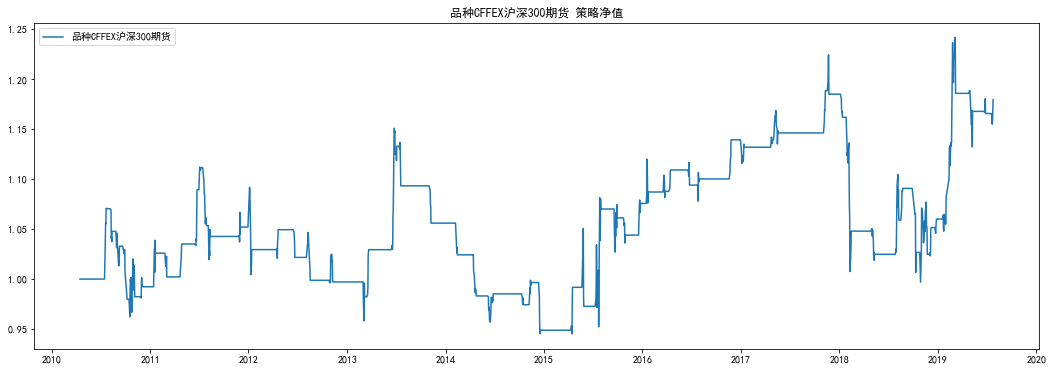

胜率 0.5326
信号周度频率 0.1941
信号IR 0.5746
窗口10
                               CFFEX沪深300期货
mean_return                       0.0179665
vol_return                          0.11342
IR                                 0.158406
sharpe_ratio                      -0.106097
max_drawdown                       0.186001
mean_return_max_drawdown_ratio    0.0965934
max_drawdown_start               2017-11-22
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                0.933607


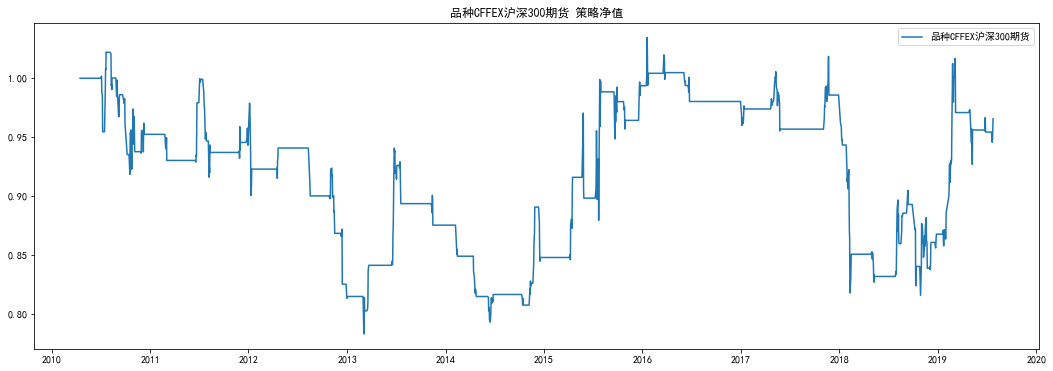

胜率 0.4796
信号周度频率 0.2068
信号IR -0.1060
窗口11
                               CFFEX沪深300期货
mean_return                     -0.00376332
vol_return                         0.116002
IR                               -0.0324419
sharpe_ratio                      -0.291059
max_drawdown                       0.233787
mean_return_max_drawdown_ratio   -0.0160972
max_drawdown_start               2010-07-22
max_drawdown_end                 2013-03-04
max_drawdown_last_Y                 2.61739


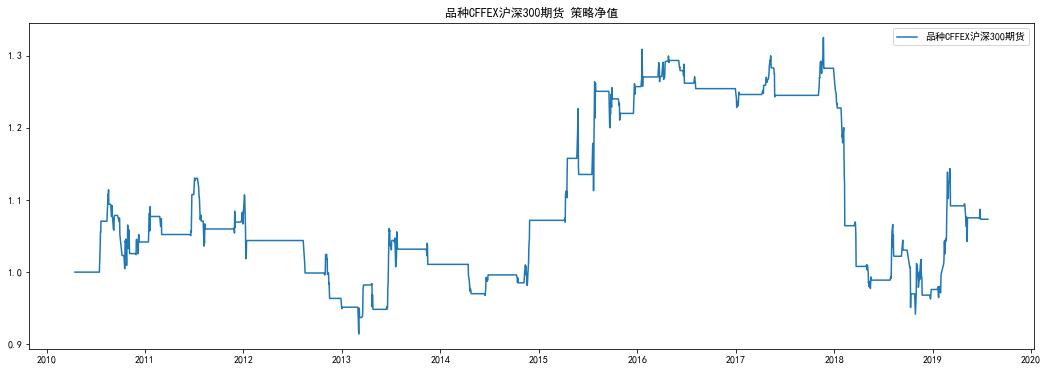

胜率 0.5052
信号周度频率 0.2046
信号IR 0.2273
窗口12
                               CFFEX沪深300期货
mean_return                      0.00765427
vol_return                         0.115076
IR                                0.0665148
sharpe_ratio                      -0.194182
max_drawdown                       0.289362
mean_return_max_drawdown_ratio    0.0264523
max_drawdown_start               2017-11-22
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                0.933607


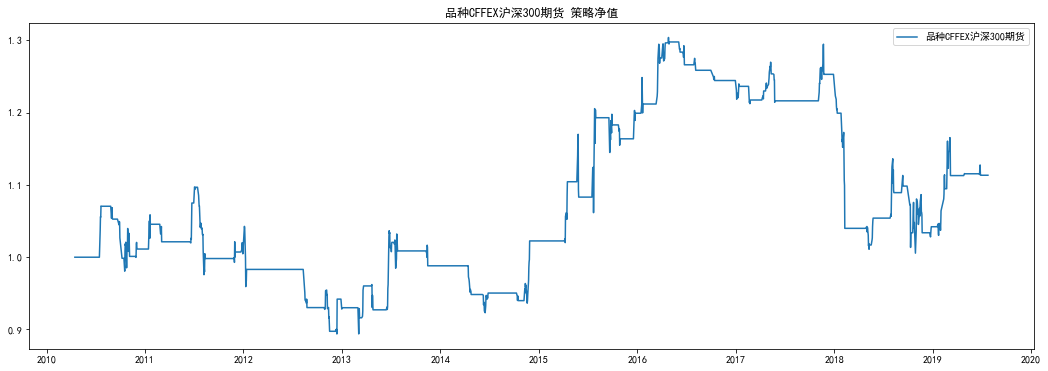

胜率 0.4848
信号周度频率 0.2089
信号IR 0.3460
窗口13
                               CFFEX沪深300期货
mean_return                       0.0116554
vol_return                         0.115268
IR                                 0.101115
sharpe_ratio                      -0.159147
max_drawdown                        0.22892
mean_return_max_drawdown_ratio    0.0509146
max_drawdown_start               2016-04-26
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                 2.50787


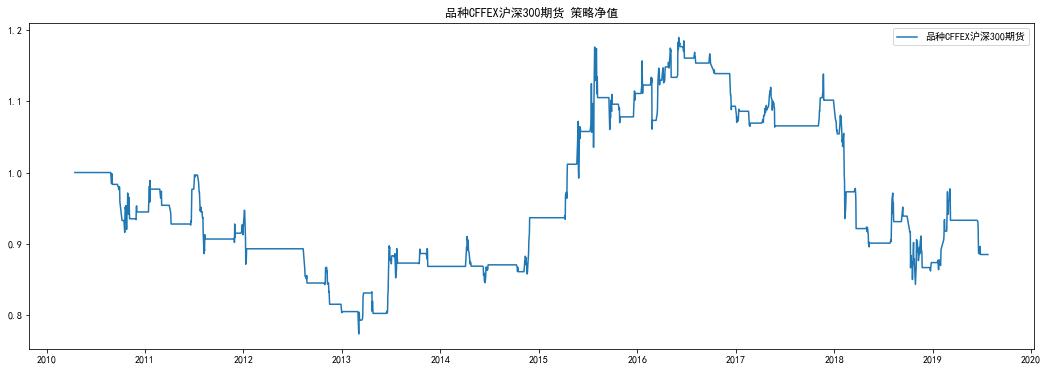

胜率 0.4554
信号周度频率 0.2363
信号IR -0.3088
窗口14
                               CFFEX沪深300期货
mean_return                      -0.0130865
vol_return                         0.126306
IR                                 -0.10361
sharpe_ratio                      -0.341129
max_drawdown                        0.29122
mean_return_max_drawdown_ratio   -0.0449369
max_drawdown_start               2016-06-03
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                 2.40383


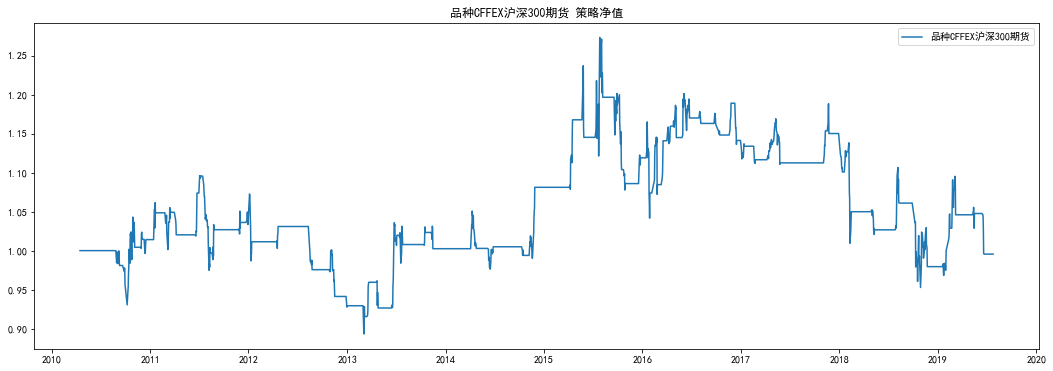

胜率 0.4622
信号周度频率 0.2511
信号IR -0.0112
窗口15
                               CFFEX沪深300期货
mean_return                    -0.000482731
vol_return                         0.129521
IR                              -0.00372705
sharpe_ratio                       -0.23535
max_drawdown                       0.251923
mean_return_max_drawdown_ratio  -0.00191619
max_drawdown_start               2015-07-27
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                 3.25804


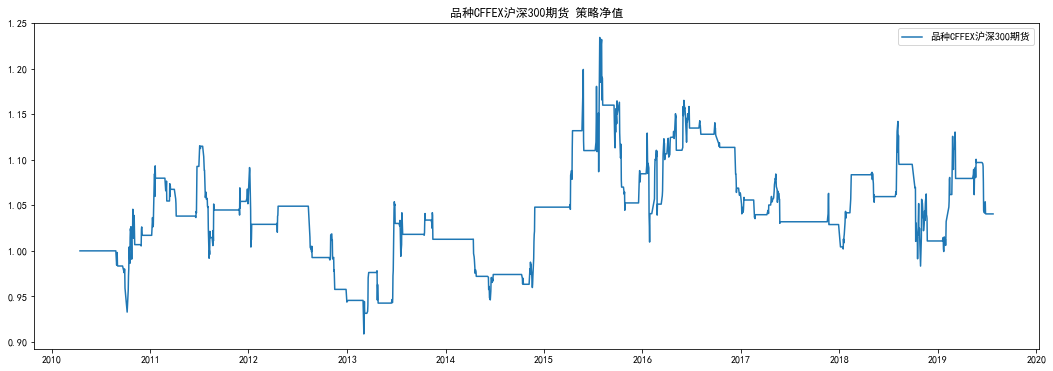

胜率 0.4609
信号周度频率 0.2426
信号IR 0.1048
窗口16
                               CFFEX沪深300期货
mean_return                      0.00429864
vol_return                         0.126555
IR                                0.0339667
sharpe_ratio                      -0.203085
max_drawdown                       0.203438
mean_return_max_drawdown_ratio      0.02113
max_drawdown_start               2015-07-27
max_drawdown_end                 2018-10-29
max_drawdown_last_Y                 3.25804


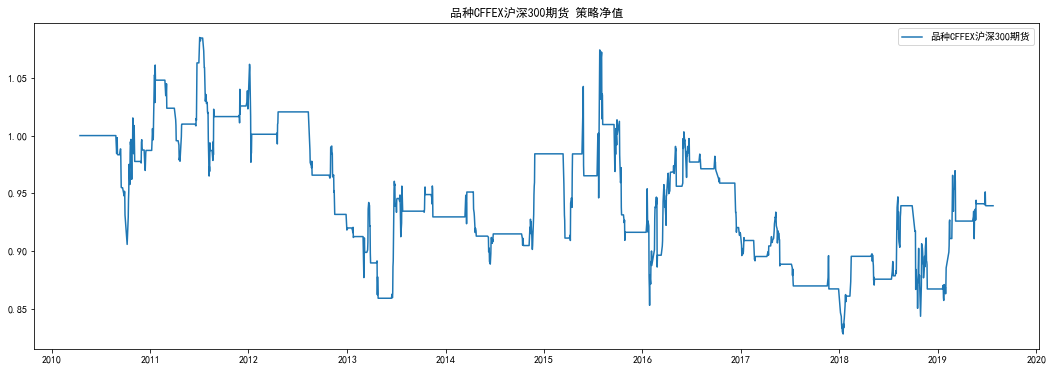

胜率 0.4603
信号周度频率 0.2658
信号IR -0.1508
窗口17
                               CFFEX沪深300期货
mean_return                     -0.00674606
vol_return                         0.128042
IR                               -0.0526865
sharpe_ratio                      -0.286985
max_drawdown                       0.236979
mean_return_max_drawdown_ratio   -0.0284669
max_drawdown_start               2011-07-04
max_drawdown_end                 2018-01-15
max_drawdown_last_Y                 6.53525


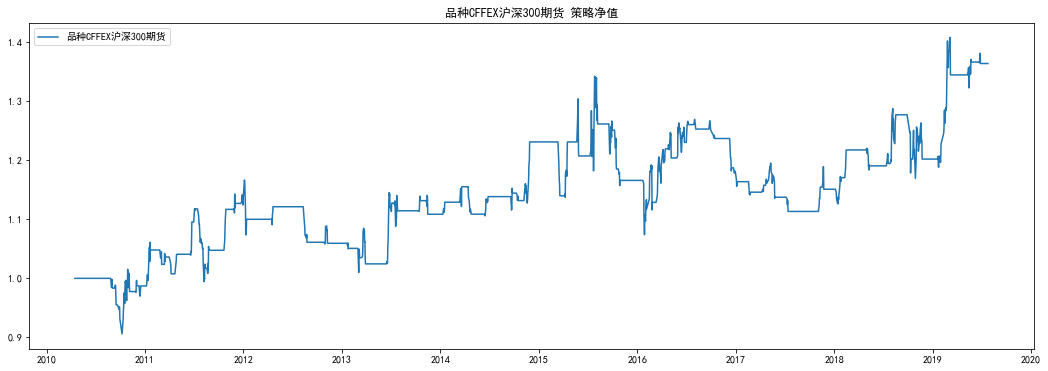

胜率 0.5081
信号周度频率 0.2616
信号IR 0.8367
窗口18
                               CFFEX沪深300期货
mean_return                       0.0340707
vol_return                         0.128611
IR                                 0.264914
sharpe_ratio                      0.0316516
max_drawdown                       0.200078
mean_return_max_drawdown_ratio     0.170287
max_drawdown_start               2015-07-27
max_drawdown_end                 2016-01-28
max_drawdown_last_Y                0.506502


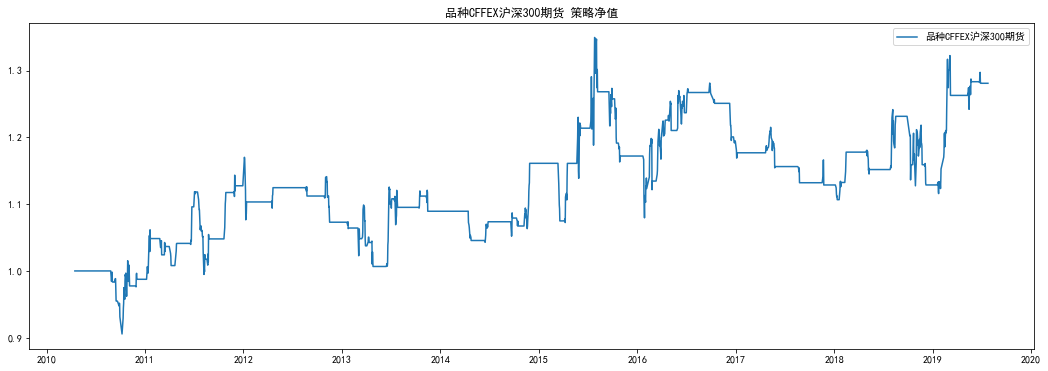

胜率 0.5000
信号周度频率 0.2489
信号IR 0.6655
窗口19
                               CFFEX沪深300期货
mean_return                       0.0270571
vol_return                         0.130108
IR                                 0.207959
sharpe_ratio                     -0.0226187
max_drawdown                       0.200078
mean_return_max_drawdown_ratio     0.135233
max_drawdown_start               2015-07-27
max_drawdown_end                 2016-01-28
max_drawdown_last_Y                0.506502


In [456]:
WindowList = np.arange(2,20,1)
for WindowL in WindowList:

    dBdSDf_Week = pd.DataFrame({'日期':dateList_,'多单beta':longbetaList_,'空单beta':shortbetaList_,}).set_index('日期')
    dBdSDf_Week_pct = (dBdSDf_Week - dBdSDf_Week.rolling(WindowL).mean()).copy()
    dBdSDf_Week_pct['Signal'] = dBdSDf_Week_pct.apply(lambda x: 1 if x['多单beta']>0 and x['空单beta']<0 else -1 if x['多单beta']<0 and x['空单beta']>0 else 0,axis=1)

    SignalDF = dBdSDf_Week_pct.copy()
    OandCandSignalDf = OandCpriceData.merge(SignalDF,left_index=True,right_index=True,how='left')
    OandCandSignalDf['Signal_END'] = OandCandSignalDf['Signal'].shift(1).fillna(method='ffill')
#     OandCandSignalDf['Signal_Change'] = (OandCandSignalDf['Signal_END'] - OandCandSignalDf['Signal_END'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
    OandCandSignalDf = OandCandSignalDf.merge(IfFirst,left_index=True,right_index=True,how='left').merge(IfLast,left_index=True,right_index=True,how='left').copy()

    ########### 储存各类信息 ###########
    dateList = OandCandSignalDf.index.tolist()
    opriceList = OandCandSignalDf[KIND+'open'].tolist()
    cpriceList = OandCandSignalDf[KIND+'close'].tolist()
    Signal_ENDList = OandCandSignalDf['Signal_END'].tolist()
    IfFirstList = OandCandSignalDf['IfFirst'].tolist()
    IfLastList = OandCandSignalDf['IfLast'].tolist()
    ############ 初始化状态 ###########
    equity = 1
    Nshare = 0
    L = 0
    equityList = []
    MainContractCode = 0
    ############ 循环执行策略 ###########
    for dateCnt in range(len(dateList)):
        ## 更新每日信息
        date = dateList[dateCnt]
        date_last = dateList[dateCnt-1]
        cprice = cpriceList[dateCnt]
        oprice = opriceList[dateCnt]
        last_cprice = cpriceList[dateCnt-1]
        Signal_END = Signal_ENDList[dateCnt]
        ifFirst = IfFirstList[dateCnt]
        ifLast = IfLastList[dateCnt]

        ## 当日信号为 缺失值
        if np.isnan(Signal_END):
            equityList.append(equity)
            continue

        ## 判断是否为周内首日
        if ifFirst == 1:
            MainContractCode = MainContractKIND.loc[date,][0]
            TodayContract = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()
            MainCopen = TodayContract['开盘价'].tolist()[0]
            MainCclose = TodayContract['收盘价'].tolist()[0]
            L = Signal_END
            Nshare = equity/MainCopen
            dequity = Nshare*(MainCclose-MainCopen)*L
        else:
            if L == 0:
                dequity = 0
            else:
                MainCclose = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()['收盘价'].tolist()[0]
                MainCclose_last = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date_last)].copy()['收盘价'].tolist()[0]
                dequity = Nshare*(MainCclose-MainCclose_last)*L
        ## 判断是否为周内最后日
        if ifLast == 1:
            ## 清仓
            N = 0
            L = 0
        ## 输出今日净值
        equity += dequity
        equityList.append(equity)

    equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}).set_index('日期')
    # CloseDataForKIND_withResult = CloseDataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}),on=['日期'])
    
    ############ 结果输出 ###########
    # 图像
    plt.figure(figsize=(18,6))
    plt.plot(equityDf_KIND,label='品种%s'%(KIND))
    plt.title('品种%s'%(KIND)+' 策略净值')
    plt.legend(loc=0)
    plt.show()

    # 胜率+频率+信号IR
    ## 胜率+频率
    WinAndFreq = pd.DataFrame(WeekDateList,columns=['日期']).merge(equityDf_KIND,left_on='日期',right_index=True).merge(OandCandSignalDf[['Signal_END']],left_on='日期',right_index=True).dropna()
    WinAndFreq[KIND+'pct_If'] = WinAndFreq[KIND].pct_change().apply(lambda x:1 if x>0 else 0)
    WinAndFreq_sub = WinAndFreq[WinAndFreq['Signal_END'] != 0]
    WinProb = WinAndFreq_sub[KIND+'pct_If'].sum()/len(WinAndFreq_sub)
    SigFreq = len(WinAndFreq_sub)/len(WinAndFreq)
    ## 信号IR
    Signal_IR = OandCandSignalDf.merge(equityDf_KIND,left_index=True,right_index=True,)
    Signal_IR = Signal_IR[(Signal_IR['Signal_END'] ==1) | (Signal_IR['Signal_END'] ==-1)][[KIND]].copy()
    miu_Y = Signal_IR[KIND].tolist()[-1]**(365.25/len(Signal_IR))-1
    std_Y = Signal_IR[KIND].pct_change().std()*252**0.5
    Signal_IR_Value = miu_Y/std_Y
    print('胜率 %.4f\n信号周度频率 %.4f\n信号IR %.4f\n窗口%d'%(WinProb,SigFreq,Signal_IR_Value,WindowL))

    # 原始指标
    print(Indicator(equityDf_KIND)[0])

# 周度策略3 - |dB-dS|/sqrt(V)筛选分两队，再比较

## 统计分析 - 会员预测涨跌幅与stats关系

In [468]:
LongShortVDf = LongShortDeltaDf['持买单'].merge(LongShortDeltaDf['持卖单'],on=['日期','公司','合约名称']).merge(LongShortDeltaDf['成交'],on=['日期','公司','合约名称'])

In [469]:
LongShortVDf['dB_dS'] = LongShortVDf['多单持仓增量'] - LongShortVDf['空单持仓增量']
LongShortVDf['dB_dS_sqrtV'] = (LongShortVDf['多单持仓增量']-LongShortVDf['空单持仓增量'])/np.sqrt(LongShortVDf['成交量'])
LongShortVDf['abs_dB_dS_sqrtV'] = np.abs(LongShortVDf['dB_dS_sqrtV'])

# def OutlinerCut(series):
#     med=np.median(series)
#     series_med=np.absolute(series-med)
#     MAD=np.median(series_med)
#     UP = med+3*MAD
#     DOWN = med-3*MAD
#     renew_one = series[-1]
#     if renew_one>UP:
#         return UP
#     if renew_one<DOWN:
#         return DOWN
#     else:
#         return renew_one
# def RollingCompute(df):
#     wind = 252
#     df = df[['dB_dS_sqrtV','日期']].set_index('日期')
#     df_ = df['dB_dS_sqrtV'].rolling(wind).apply(OutlinerCut,raw=True).to_frame('dB_dS_sqrtV_DeOut')
#     df_.iloc[:251,0] = df['dB_dS_sqrtV'].tolist()[:251]
#     return df_
# LongShortVDf = LongShortVDf.merge(LongShortVDf.groupby('公司').apply(RollingCompute).reset_index(),on=['日期','公司'])

In [470]:
LongShortVDf_ = LongShortVDf.merge(ReturnDataKIND.shift(-1).rename(columns={KIND:'pct'}),left_on='日期',right_index=True,how='left').dropna()

In [471]:
LongShortVDf_['IfRight'] = LongShortVDf_.apply(lambda x: 1 if x['dB_dS']*x['pct']>0 else 0,axis=1)

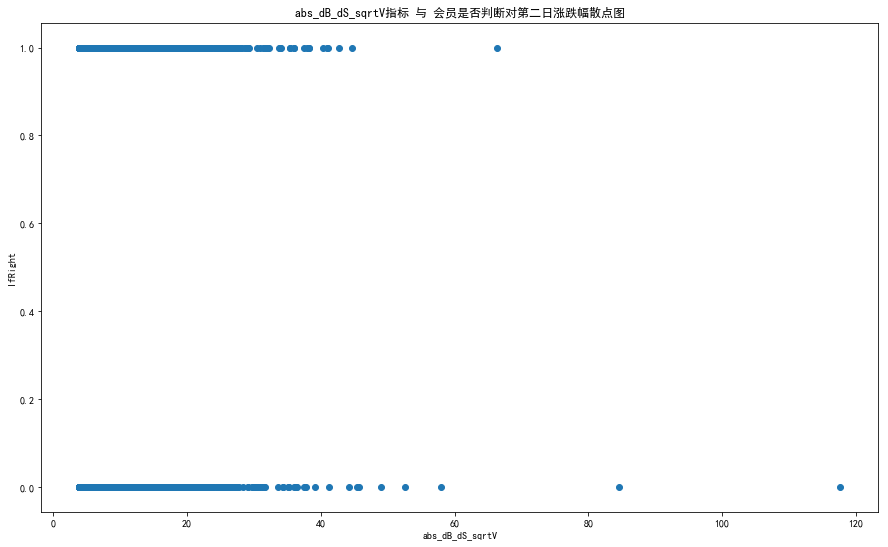

In [473]:
quantile = LongShortVDf_['abs_dB_dS_sqrtV'].quantile(0.75)
LongShortVDf_sub = LongShortVDf_[LongShortVDf_['abs_dB_dS_sqrtV']>quantile]
plt.figure(figsize=(15,9))
plt.xlabel('abs_dB_dS_sqrtV')
plt.ylabel('IfRight')
plt.title('abs_dB_dS_sqrtV指标 与 会员是否判断对第二日涨跌幅散点图')
plt.scatter(LongShortVDf_sub['abs_dB_dS_sqrtV'],LongShortVDf_sub['IfRight'])
plt.show()

## 信号计算 周内指标绝对值划分 1/2，大Vs小

In [549]:
Big_dB_List = []
Big_dS_List = []
Small_dB_List = []
Small_dS_List = []
dateList_ = []
quantile_thres = 0.5
for WeekCnt in range(1,len(WeekDateList)):
    
    WeekDate = WeekDateList[WeekCnt]
    WeekDate_last = WeekDateList[WeekCnt-1]
    LongShort_Week = LongShortVDf[(LongShortVDf['日期']<=WeekDate) & (LongShortVDf['日期']>WeekDate_last)]
    
    quantile = LongShort_Week['abs_dB_dS_sqrtV'].quantile(quantile_thres)
    BigSub = LongShort_Week[LongShort_Week['abs_dB_dS_sqrtV']>=quantile]
    SmallSub = LongShort_Week[LongShort_Week['abs_dB_dS_sqrtV']<quantile]
    BigSubSum = BigSub.sum()
    SmallSubSum = SmallSub.sum()
    Big_dB = BigSubSum['多单持仓增量']
    Big_dS = BigSubSum['空单持仓增量']
    Small_dB = SmallSubSum['多单持仓增量']
    Small_dS = SmallSubSum['空单持仓增量']
    
    Big_dB_List.append(Big_dB)
    Big_dS_List.append(Big_dS)
    Small_dB_List.append(Small_dB)
    Small_dS_List.append(Small_dS)
    
    dateList_.append(WeekDate)

In [619]:
absStatsDf = pd.DataFrame({'日期':dateList_,'Big_dB':Big_dB_List,'Big_dS':Big_dS_List,'Small_dB':Small_dB_List,'Small_dS':Small_dS_List,}).set_index('日期')
absStatsDfSignalDf = absStatsDf.apply(lambda x: 1 if (x['Big_dB']-x['Big_dS'])>(x['Small_dB']-x['Small_dS']) else -1,axis=1).to_frame('Signal')
# absStatsDfSignalDf = absStatsDf.apply(lambda x: 1 if x['Big_dB']>x['Big_dS'] and x['Small_dB'] > x['Small_dS'] else -1 if x['Big_dB']<x['Big_dS'] and x['Small_dB'] < x['Small_dS'] else 0,axis=1).to_frame('Signal')

In [620]:
# 信号与交易数据拼接 - 统一化处理
SignalDF = absStatsDfSignalDf.copy()
OandCandSignalDf = OandCpriceData.merge(SignalDF,left_index=True,right_index=True,how='left')
OandCandSignalDf['Signal_END'] = OandCandSignalDf['Signal'].shift(1).fillna(method='ffill')
# OandCandSignalDf['Signal_Change'] = (OandCandSignalDf['Signal_END'] - OandCandSignalDf['Signal_END'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
OandCandSignalDf = OandCandSignalDf.merge(IfFirst,left_index=True,right_index=True,how='left').merge(IfLast,left_index=True,right_index=True,how='left').copy()

In [621]:
########### 储存各类信息 ###########
dateList = OandCandSignalDf.index.tolist()
opriceList = OandCandSignalDf[KIND+'open'].tolist()
cpriceList = OandCandSignalDf[KIND+'close'].tolist()
Signal_ENDList = OandCandSignalDf['Signal_END'].tolist()
IfFirstList = OandCandSignalDf['IfFirst'].tolist()
IfLastList = OandCandSignalDf['IfLast'].tolist()
############ 初始化状态 ###########
equity = 1
Nshare = 0
L = 0
equityList = []
MainContractCode = 0
############ 循环执行策略 ###########
for dateCnt in range(len(dateList)):
    ## 更新每日信息
    date = dateList[dateCnt]
    date_last = dateList[dateCnt-1]
    cprice = cpriceList[dateCnt]
    oprice = opriceList[dateCnt]
    last_cprice = cpriceList[dateCnt-1]
    Signal_END = Signal_ENDList[dateCnt]
    ifFirst = IfFirstList[dateCnt]
    ifLast = IfLastList[dateCnt]
    
    ## 当日信号为 缺失值
    if np.isnan(Signal_END):
        equityList.append(equity)
        continue
    
    ## 判断是否为周内首日
    if ifFirst == 1:
        MainContractCode = MainContractKIND.loc[date,][0]
        TodayContract = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()
        MainCopen = TodayContract['开盘价'].tolist()[0]
        MainCclose = TodayContract['收盘价'].tolist()[0]
        L = Signal_END
        Nshare = equity/MainCopen
        dequity = Nshare*(MainCclose-MainCopen)*L
    else:
        if L == 0:
            dequity = 0
        else:
            MainCclose = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()['收盘价'].tolist()[0]
            MainCclose_last = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date_last)].copy()['收盘价'].tolist()[0]
            dequity = Nshare*(MainCclose-MainCclose_last)*L
    ## 判断是否为周内最后日
    if ifLast == 1:
        ## 清仓
        N = 0
        L = 0
    ## 输出今日净值
    equity += dequity
    equityList.append(equity)

equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}).set_index('日期')
# CloseDataForKIND_withResult = CloseDataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}),on=['日期'])

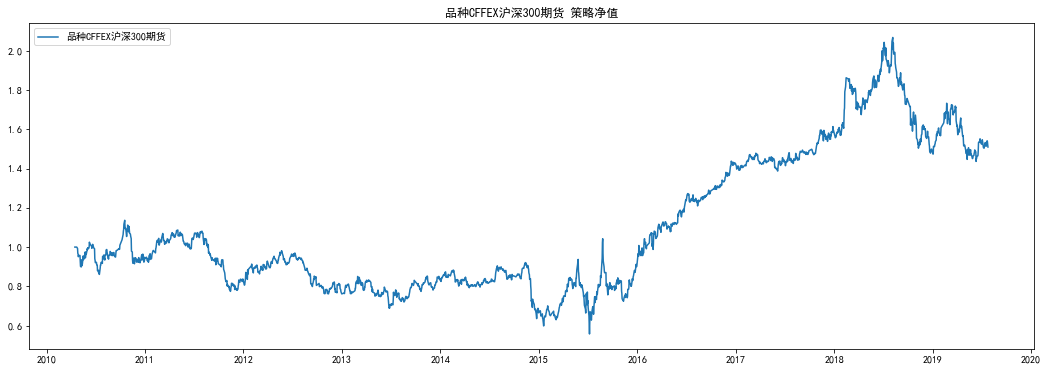

胜率 0.5253
信号周度频率 1.0000
信号IR 0.2787
                               CFFEX沪深300期货
mean_return                       0.0454233
vol_return                         0.247803
IR                                 0.183304
sharpe_ratio                      0.0622401
max_drawdown                       0.509655
mean_return_max_drawdown_ratio    0.0891256
max_drawdown_start               2010-10-18
max_drawdown_end                 2015-07-08
max_drawdown_last_Y                 4.72005


In [622]:
############ 结果输出 ###########
# 图像
plt.figure(figsize=(18,6))
plt.plot(equityDf_KIND,label='品种%s'%(KIND))
plt.title('品种%s'%(KIND)+' 策略净值')
plt.legend(loc=0)
plt.show()

# 胜率+频率+信号IR
## 胜率+频率
WinAndFreq = pd.DataFrame(WeekDateList,columns=['日期']).merge(equityDf_KIND,left_on='日期',right_index=True).merge(OandCandSignalDf[['Signal_END']],left_on='日期',right_index=True).dropna()
WinAndFreq[KIND+'pct_If'] = WinAndFreq[KIND].pct_change().apply(lambda x:1 if x>0 else 0)
WinAndFreq_sub = WinAndFreq[WinAndFreq['Signal_END'] != 0]
WinProb = WinAndFreq_sub[KIND+'pct_If'].sum()/len(WinAndFreq_sub)
SigFreq = len(WinAndFreq_sub)/len(WinAndFreq)
## 信号IR
Signal_IR = OandCandSignalDf.merge(equityDf_KIND,left_index=True,right_index=True,)
Signal_IR = Signal_IR[(Signal_IR['Signal_END'] ==1) | (Signal_IR['Signal_END'] ==-1)][[KIND]].copy()
miu_Y = Signal_IR[KIND].tolist()[-1]**(365.25/len(Signal_IR))-1
std_Y = Signal_IR[KIND].pct_change().std()*252**0.5
Signal_IR_Value = miu_Y/std_Y
print('胜率 %.4f\n信号周度频率 %.4f\n信号IR %.4f'%(WinProb,SigFreq,Signal_IR_Value))

# 原始指标
print(Indicator(equityDf_KIND)[0])

# 周度策略4 动量嵌入

## 周度信号计算+循环回测调参

In [19]:
# 周度价格数据
OandCpriceData_ = OandCpriceData.copy()
OandCpriceData_['日期'] = OandCpriceData_.index
OandCpriceData_Week_price = OandCpriceData_.apply(lambda x: x.resample('W').last()).set_index('日期').dropna().reset_index()

F:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


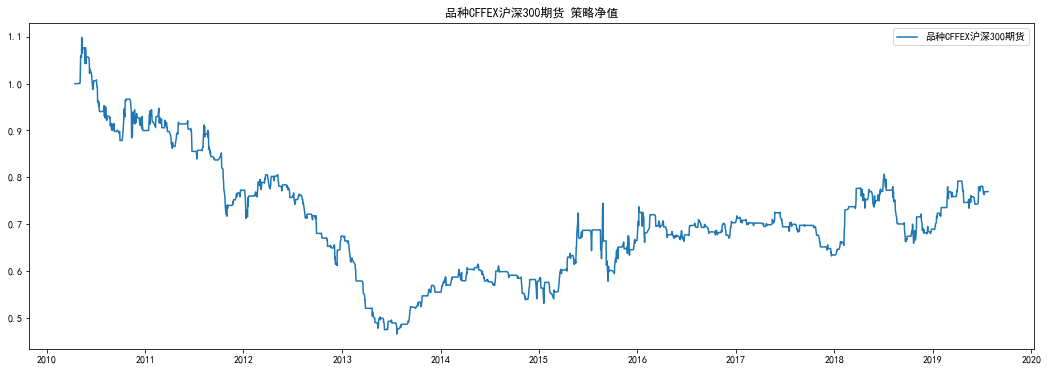

胜率 0.4723
信号周度频率 0.4958
信号IR -0.3414
动量窗口 1 动量阈值 0.001
                               CFFEX沪深300期货
mean_return                      -0.0279103
vol_return                         0.168748
IR                                -0.165396
sharpe_ratio                      -0.343175
max_drawdown                       0.576717
mean_return_max_drawdown_ratio    -0.048395
max_drawdown_start               2010-05-11
max_drawdown_end                 2013-07-23
max_drawdown_last_Y                 3.20055


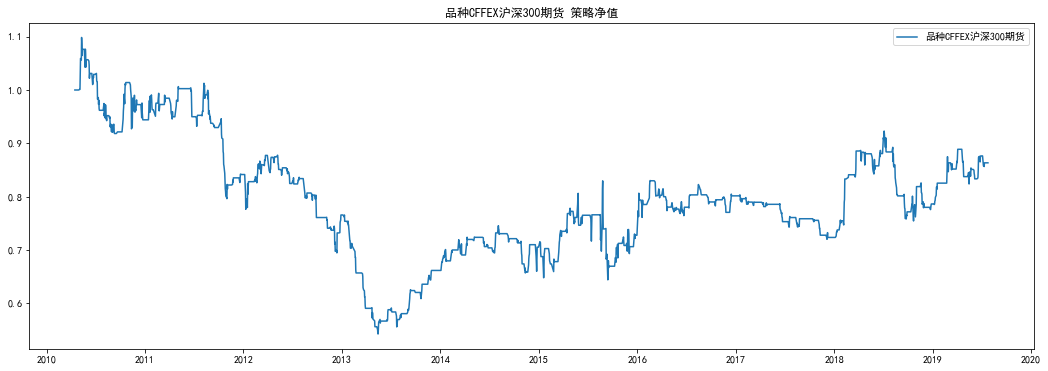

胜率 0.4950
信号周度频率 0.4219
信号IR -0.2186
动量窗口 1 动量阈值 0.006
                               CFFEX沪深300期货
mean_return                      -0.0157292
vol_return                         0.161968
IR                                -0.097113
sharpe_ratio                      -0.282335
max_drawdown                       0.506661
mean_return_max_drawdown_ratio   -0.0310448
max_drawdown_start               2010-05-11
max_drawdown_end                 2013-05-15
max_drawdown_last_Y                 3.01164


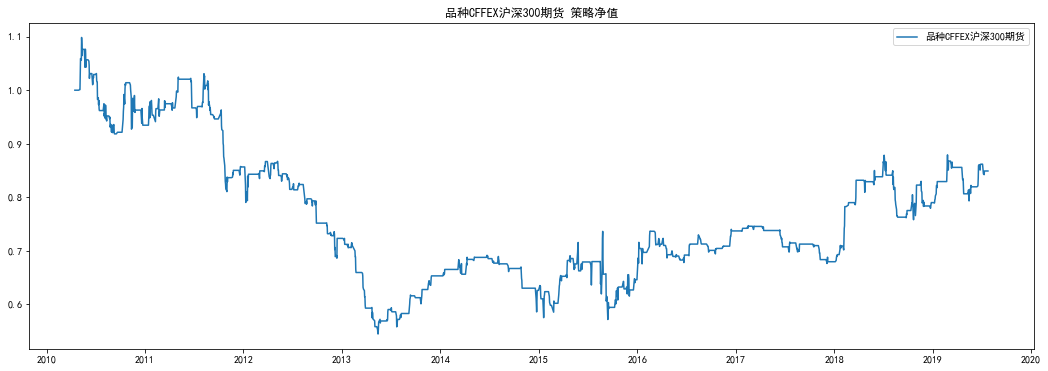

胜率 0.5000
信号周度频率 0.3629
信号IR -0.2696
动量窗口 1 动量阈值 0.011
                               CFFEX沪深300期货
mean_return                       -0.017512
vol_return                          0.15654
IR                                -0.111869
sharpe_ratio                      -0.303514
max_drawdown                       0.504797
mean_return_max_drawdown_ratio   -0.0346911
max_drawdown_start               2010-05-11
max_drawdown_end                 2013-05-15
max_drawdown_last_Y                 3.01164


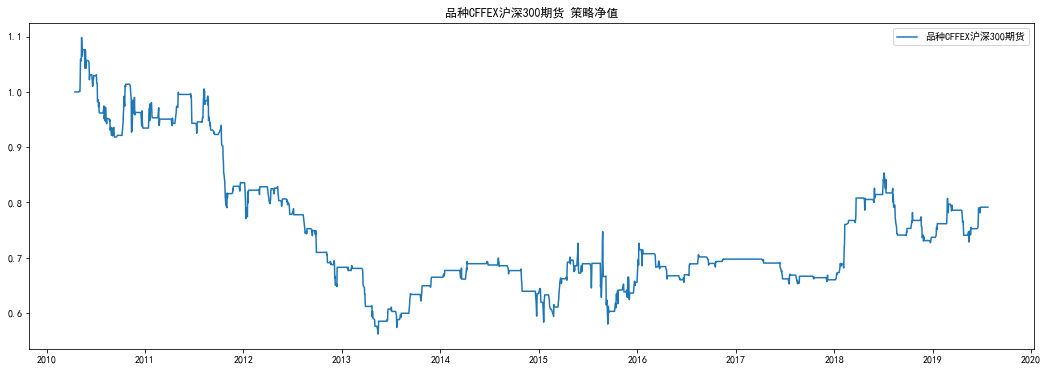

胜率 0.4863
信号周度频率 0.3080
信号IR -0.4225
动量窗口 1 动量阈值 0.016
                               CFFEX沪深300期货
mean_return                      -0.0249251
vol_return                         0.150862
IR                                -0.165218
sharpe_ratio                      -0.364075
max_drawdown                       0.488675
mean_return_max_drawdown_ratio   -0.0510055
max_drawdown_start               2010-05-11
max_drawdown_end                 2013-05-15
max_drawdown_last_Y                 3.01164


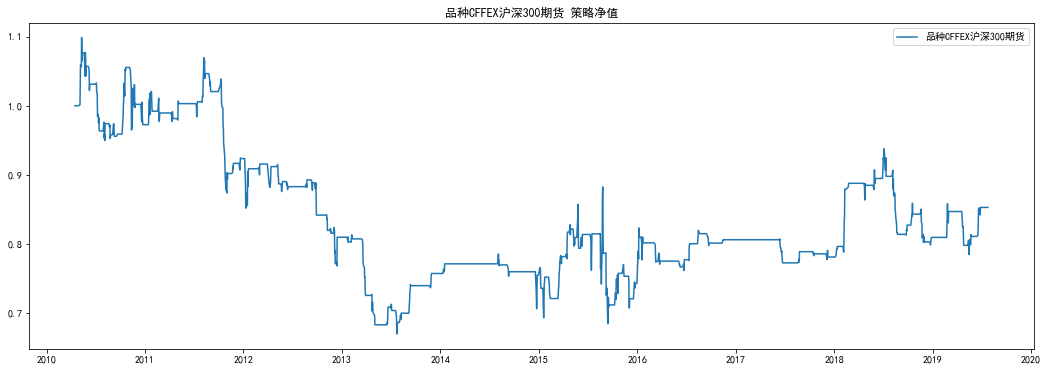

胜率 0.5000
信号周度频率 0.2489
信号IR -0.3421
动量窗口 1 动量阈值 0.021
                               CFFEX沪深300期货
mean_return                      -0.0169984
vol_return                          0.14202
IR                                 -0.11969
sharpe_ratio                      -0.330927
max_drawdown                       0.390038
mean_return_max_drawdown_ratio   -0.0435814
max_drawdown_start               2010-05-11
max_drawdown_end                 2013-07-23
max_drawdown_last_Y                 3.20055


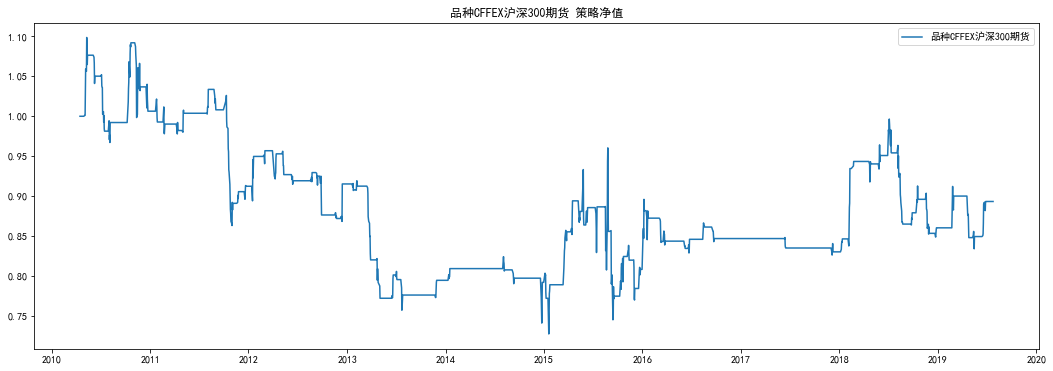

胜率 0.4845
信号周度频率 0.2046
信号IR -0.2859
动量窗口 1 动量阈值 0.026
                               CFFEX沪深300期货
mean_return                      -0.0120866
vol_return                         0.133726
IR                               -0.0903831
sharpe_ratio                      -0.314723
max_drawdown                        0.33775
mean_return_max_drawdown_ratio   -0.0357856
max_drawdown_start               2010-05-11
max_drawdown_end                 2015-01-19
max_drawdown_last_Y                 4.69268


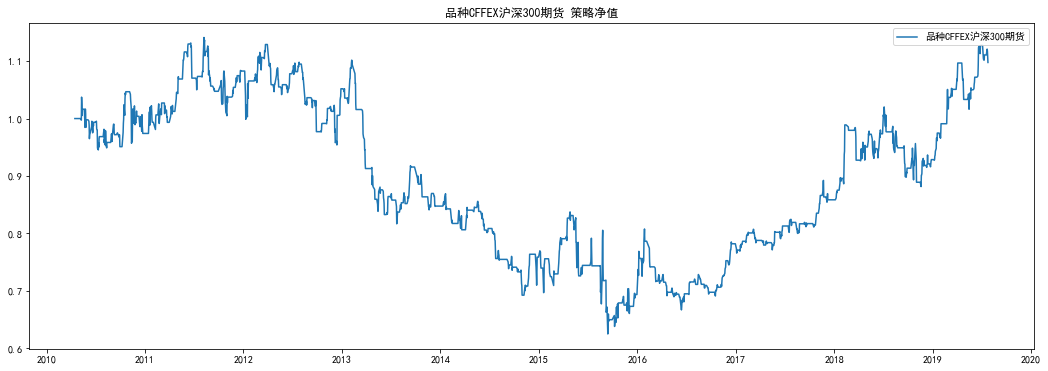

胜率 0.5230
信号周度频率 0.5053
信号IR 0.1269
动量窗口 2 动量阈值 0.001
                               CFFEX沪深300期货
mean_return                       0.0100932
vol_return                         0.169168
IR                                0.0596634
sharpe_ratio                      -0.117675
max_drawdown                       0.452145
mean_return_max_drawdown_ratio    0.0223228
max_drawdown_start               2011-08-08
max_drawdown_end                 2015-09-14
max_drawdown_last_Y                  4.1013


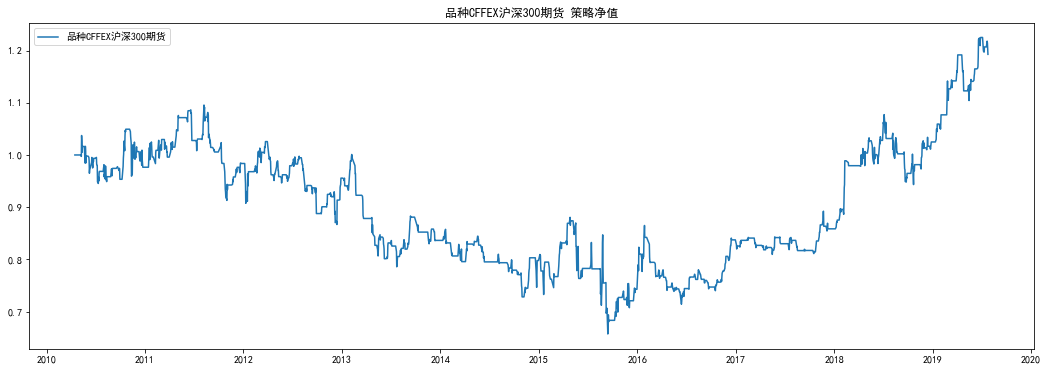

胜率 0.5204
信号周度频率 0.4672
信号IR 0.2603
动量窗口 2 动量阈值 0.006
                               CFFEX沪深300期货
mean_return                       0.0191808
vol_return                         0.164827
IR                                  0.11637
sharpe_ratio                     -0.0656397
max_drawdown                        0.40009
mean_return_max_drawdown_ratio    0.0479413
max_drawdown_start               2011-08-08
max_drawdown_end                 2015-09-14
max_drawdown_last_Y                  4.1013


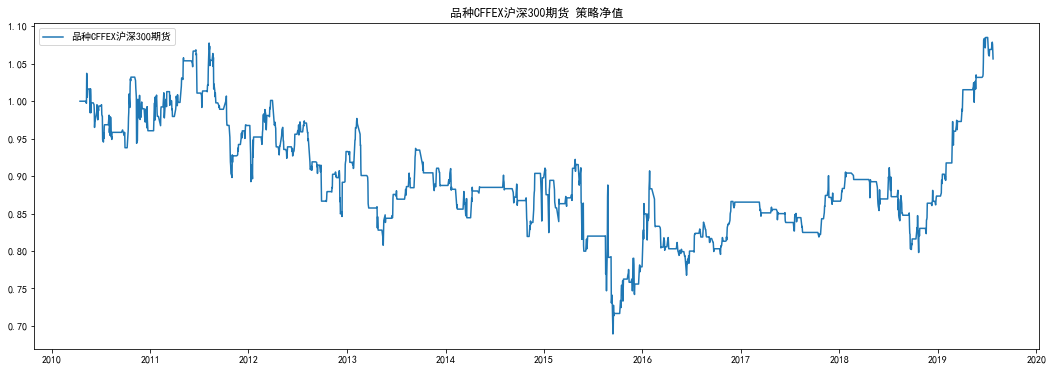

胜率 0.5156
信号周度频率 0.4059
信号IR 0.0895
动量窗口 2 动量阈值 0.011
                               CFFEX沪深300期货
mean_return                       0.0059451
vol_return                         0.157192
IR                                0.0378205
sharpe_ratio                      -0.153028
max_drawdown                       0.360545
mean_return_max_drawdown_ratio    0.0164892
max_drawdown_start               2011-08-08
max_drawdown_end                 2015-09-14
max_drawdown_last_Y                  4.1013


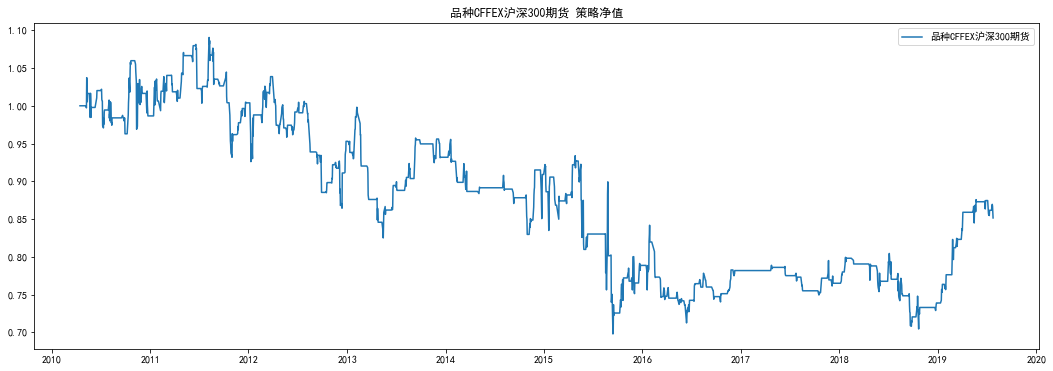

胜率 0.5118
信号周度频率 0.3594
信号IR -0.2778
动量窗口 2 动量阈值 0.016
                               CFFEX沪深300期货
mean_return                      -0.0171918
vol_return                         0.150313
IR                                -0.114373
sharpe_ratio                      -0.313956
max_drawdown                       0.360081
mean_return_max_drawdown_ratio   -0.0477442
max_drawdown_start               2011-08-08
max_drawdown_end                 2015-09-14
max_drawdown_last_Y                  4.1013


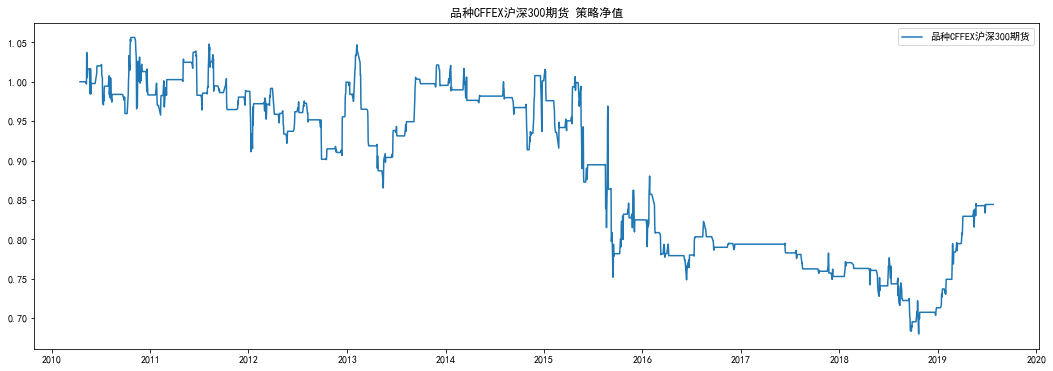

胜率 0.5145
信号周度频率 0.2918
信号IR -0.3407
动量窗口 2 动量阈值 0.021
                               CFFEX沪深300期货
mean_return                      -0.0180731
vol_return                         0.141617
IR                                 -0.12762
sharpe_ratio                      -0.339459
max_drawdown                       0.356034
mean_return_max_drawdown_ratio   -0.0507624
max_drawdown_start               2010-11-05
max_drawdown_end                 2018-10-22
max_drawdown_last_Y                 7.96167


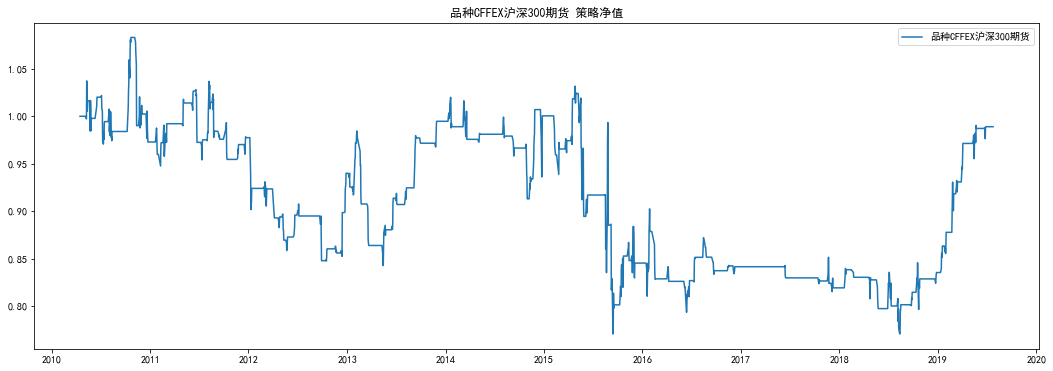

胜率 0.5328
信号周度频率 0.2579
信号IR -0.0259
动量窗口 2 动量阈值 0.026
                               CFFEX沪深300期货
mean_return                     -0.00119061
vol_return                         0.135424
IR                              -0.00879174
sharpe_ratio                      -0.230318
max_drawdown                       0.288152
mean_return_max_drawdown_ratio  -0.00413189
max_drawdown_start               2010-11-05
max_drawdown_end                 2018-08-13
max_drawdown_last_Y                 7.77002


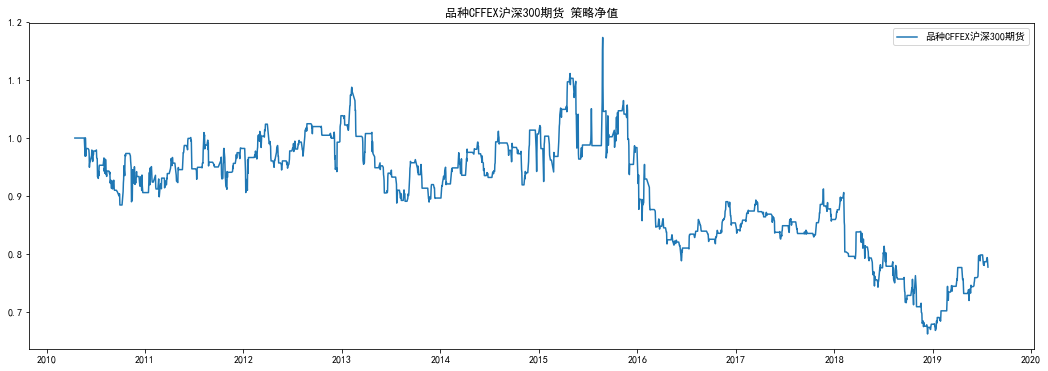

胜率 0.4807
信号周度频率 0.4936
信号IR -0.3361
动量窗口 3 动量阈值 0.001
                               CFFEX沪深300期货
mean_return                      -0.0268232
vol_return                         0.166083
IR                                -0.161505
sharpe_ratio                      -0.342138
max_drawdown                       0.436187
mean_return_max_drawdown_ratio   -0.0614947
max_drawdown_start               2015-08-26
max_drawdown_end                 2018-12-13
max_drawdown_last_Y                 3.29911


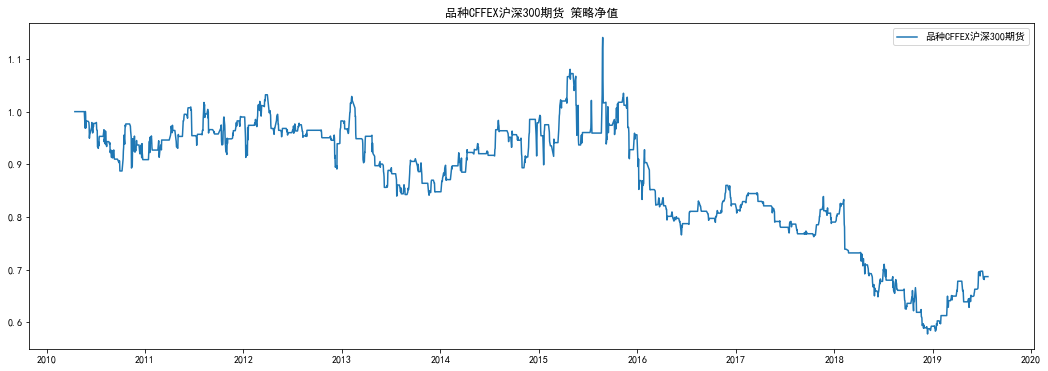

胜率 0.4747
信号周度频率 0.4597
信号IR -0.5121
动量窗口 3 动量阈值 0.006
                               CFFEX沪深300期货
mean_return                      -0.0397023
vol_return                         0.163918
IR                                -0.242208
sharpe_ratio                      -0.425226
max_drawdown                       0.493394
mean_return_max_drawdown_ratio   -0.0804679
max_drawdown_start               2015-08-26
max_drawdown_end                 2018-12-13
max_drawdown_last_Y                 3.29911


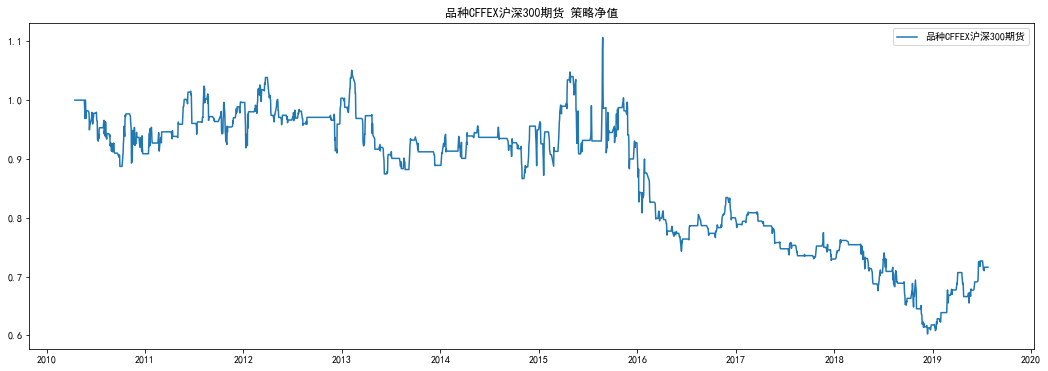

胜率 0.4776
信号周度频率 0.4258
信号IR -0.4878
动量窗口 3 动量阈值 0.011
                               CFFEX沪深300期货
mean_return                       -0.035415
vol_return                         0.159645
IR                                -0.221836
sharpe_ratio                      -0.409752
max_drawdown                       0.455729
mean_return_max_drawdown_ratio   -0.0777106
max_drawdown_start               2015-08-26
max_drawdown_end                 2018-12-13
max_drawdown_last_Y                 3.29911


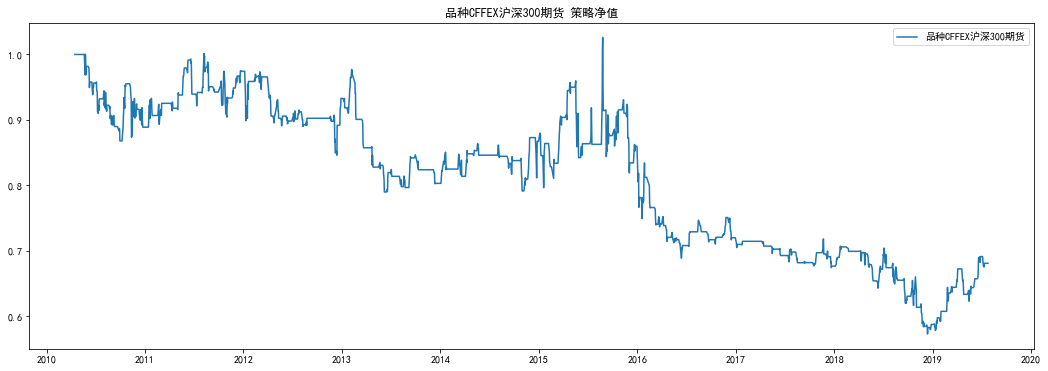

胜率 0.4706
信号周度频率 0.3962
信号IR -0.5794
动量窗口 3 动量阈值 0.016
                               CFFEX沪深300期货
mean_return                      -0.0405736
vol_return                         0.157532
IR                                -0.257557
sharpe_ratio                      -0.447994
max_drawdown                       0.441416
mean_return_max_drawdown_ratio    -0.091917
max_drawdown_start               2015-08-26
max_drawdown_end                 2018-12-13
max_drawdown_last_Y                 3.29911


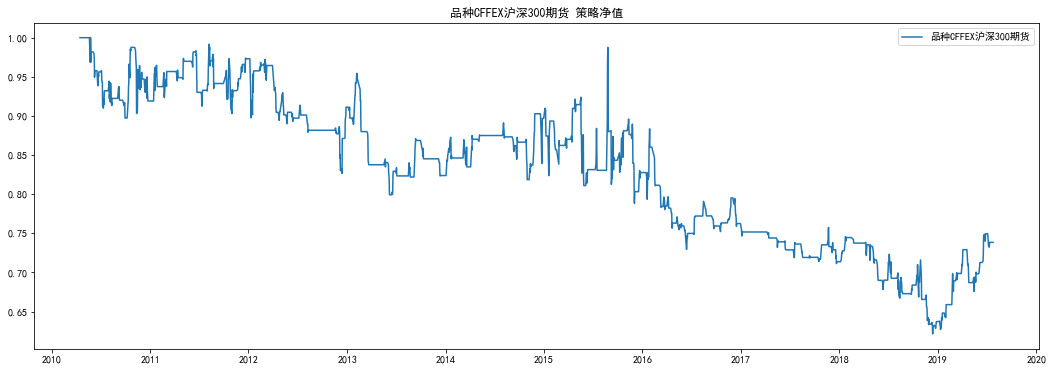

胜率 0.4765
信号周度频率 0.3602
信号IR -0.5032
动量窗口 3 动量阈值 0.021
                               CFFEX沪深300期货
mean_return                      -0.0321752
vol_return                         0.151395
IR                                -0.212525
sharpe_ratio                      -0.410683
max_drawdown                       0.378858
mean_return_max_drawdown_ratio   -0.0849268
max_drawdown_start               2010-05-25
max_drawdown_end                 2018-12-13
max_drawdown_last_Y                 8.55305


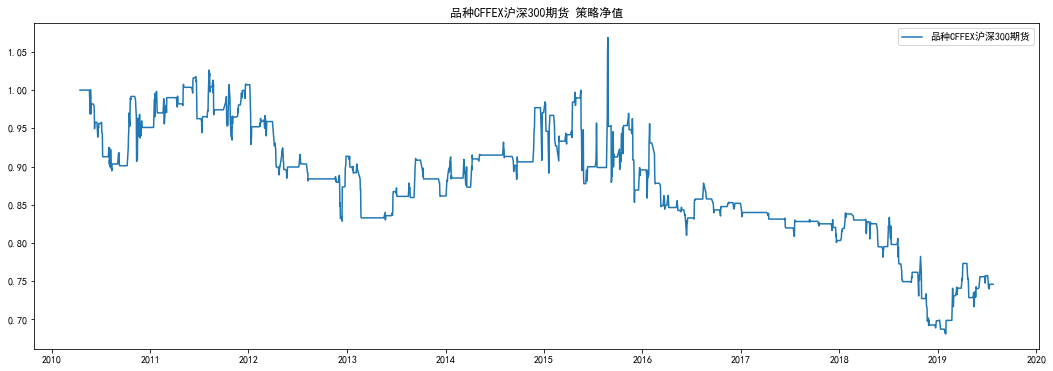

胜率 0.4897
信号周度频率 0.3072
信号IR -0.5528
动量窗口 3 动量阈值 0.026
                               CFFEX沪深300期货
mean_return                      -0.0310921
vol_return                         0.143153
IR                                -0.217195
sharpe_ratio                      -0.426762
max_drawdown                       0.362777
mean_return_max_drawdown_ratio   -0.0857057
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


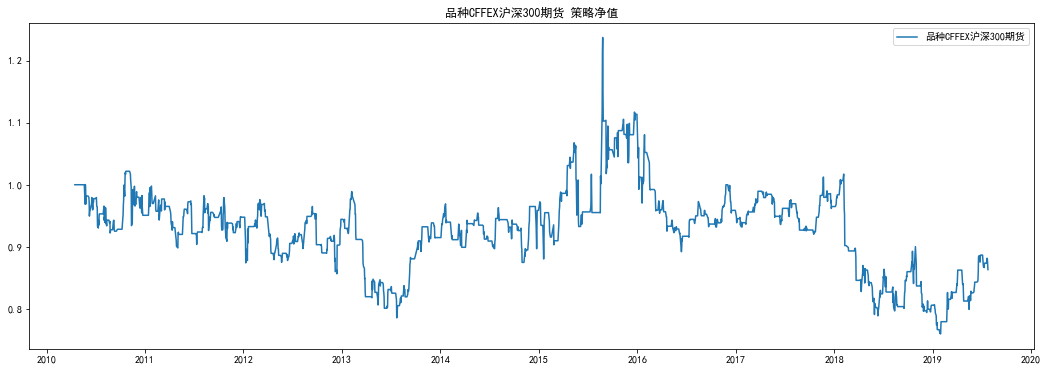

胜率 0.5042
信号周度频率 0.5011
信号IR -0.1959
动量窗口 4 动量阈值 0.001
                               CFFEX沪深300期货
mean_return                      -0.0157227
vol_return                         0.167748
IR                               -0.0937279
sharpe_ratio                      -0.272568
max_drawdown                       0.385926
mean_return_max_drawdown_ratio   -0.0407401
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


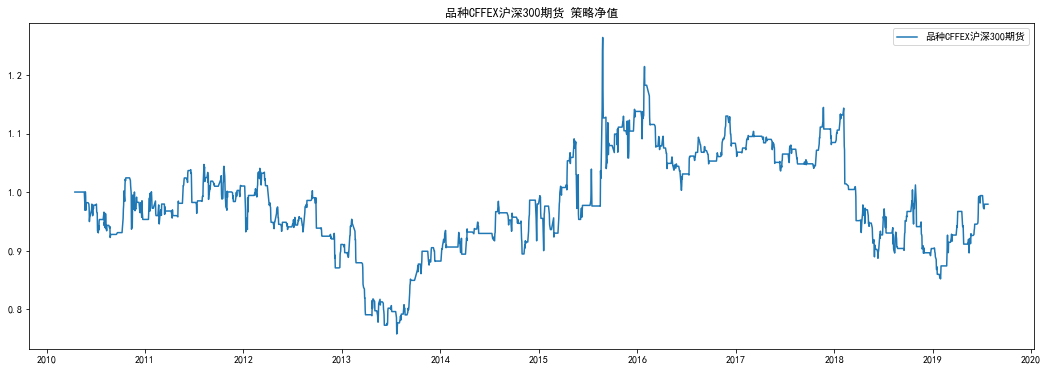

胜率 0.5138
信号周度频率 0.4628
信号IR -0.0307
动量窗口 4 动量阈值 0.006
                               CFFEX沪深300期货
mean_return                     -0.00225918
vol_return                          0.16214
IR                               -0.0139335
sharpe_ratio                      -0.198959
max_drawdown                       0.326445
mean_return_max_drawdown_ratio  -0.00692055
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


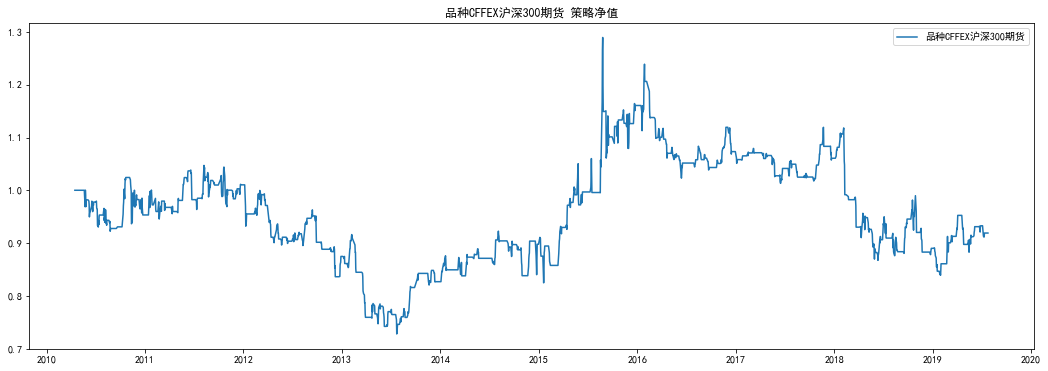

胜率 0.5072
信号周度频率 0.4437
信号IR -0.1290
动量窗口 4 动量阈值 0.011
                               CFFEX沪深300期货
mean_return                     -0.00907765
vol_return                         0.157038
IR                               -0.0578056
sharpe_ratio                      -0.248843
max_drawdown                       0.349555
mean_return_max_drawdown_ratio   -0.0259692
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


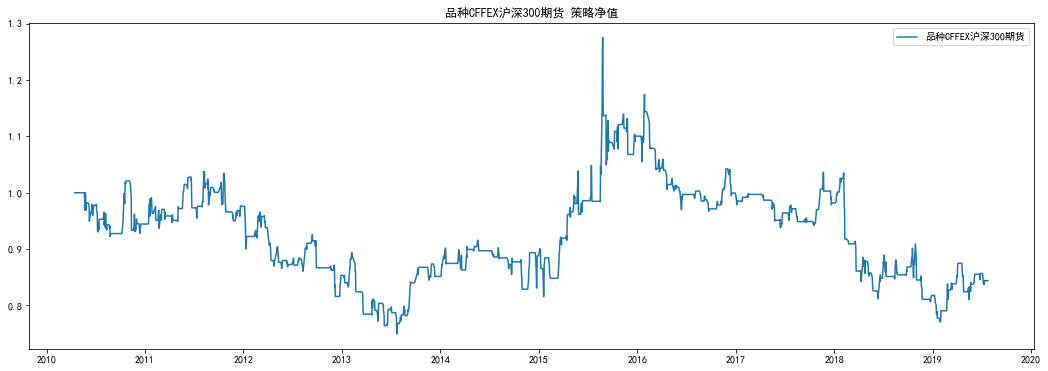

胜率 0.4948
信号周度频率 0.4076
信号IR -0.2753
动量窗口 4 动量阈值 0.016
                               CFFEX沪深300期货
mean_return                      -0.0181175
vol_return                         0.151195
IR                                -0.119829
sharpe_ratio                      -0.318248
max_drawdown                       0.395939
mean_return_max_drawdown_ratio   -0.0457582
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


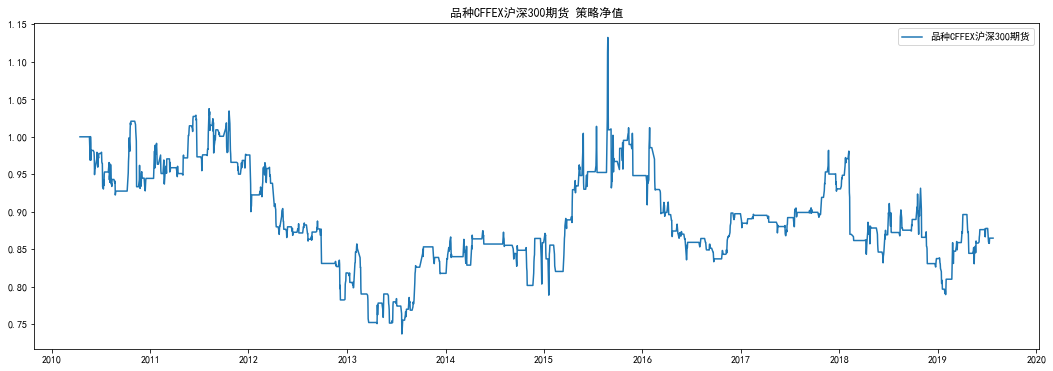

胜率 0.5000
信号周度频率 0.3822
信号IR -0.2514
动量窗口 4 动量阈值 0.021
                               CFFEX沪深300期货
mean_return                      -0.0155501
vol_return                         0.146947
IR                                -0.105821
sharpe_ratio                      -0.309977
max_drawdown                       0.303055
mean_return_max_drawdown_ratio   -0.0513112
max_drawdown_start               2015-08-26
max_drawdown_end                 2019-01-30
max_drawdown_last_Y                 3.43053


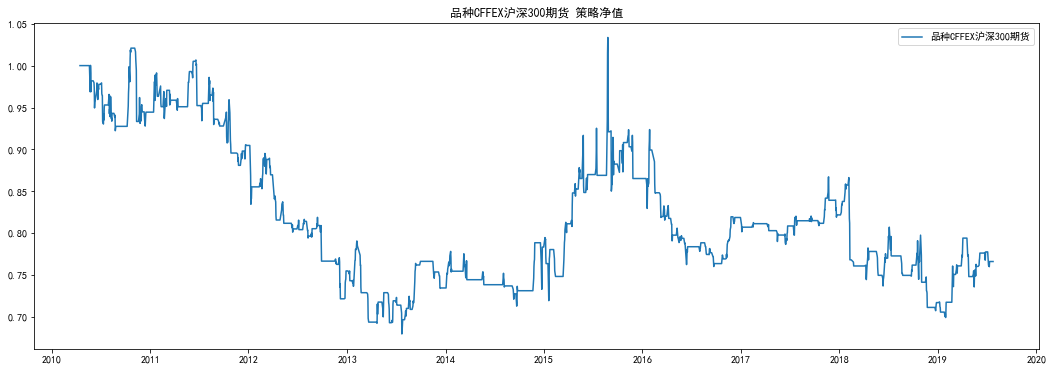

胜率 0.4790
信号周度频率 0.3546
信号IR -0.4734
动量窗口 4 动量阈值 0.026
                               CFFEX沪深300期货
mean_return                      -0.0282894
vol_return                         0.143943
IR                                -0.196531
sharpe_ratio                      -0.404946
max_drawdown                       0.333933
mean_return_max_drawdown_ratio   -0.0847157
max_drawdown_start               2010-11-05
max_drawdown_end                 2013-07-23
max_drawdown_last_Y                 2.71321


In [20]:
mom_windList = [1,2,3,4]
thresMomList = np.arange(0.001,0.03,0.005)
indicator = 'dB_dS_sqrtV'
for mom_wind in mom_windList:
    for thresMom in thresMomList:
        ######################## S1:一周，指标的sigma变化，叠加动量 ########################
        dB_dS_sqrtV_std_List = []
        dateList = []
        momList = []
        for WeekCnt in range(mom_wind,len(WeekDateList)):

            WeekDate = WeekDateList[WeekCnt]
            WeekDate_last = WeekDateList[WeekCnt-1]
            WeekDate_lastForMom = WeekDateList[WeekCnt-mom_wind]

            LongShortVDf_CGrp_Week = LongShortVDf_CGrp[(LongShortVDf_CGrp['日期']<=WeekDate) 
                                                       & (LongShortVDf_CGrp['日期']>WeekDate_last)]
            OandCpriceData_Week_price_thisW = OandCpriceData_Week_price[(OandCpriceData_Week_price['日期']<=WeekDate) 
                                                                        & (OandCpriceData_Week_price['日期']>=WeekDate_lastForMom)]

            mom = OandCpriceData_Week_price_thisW[KIND+'close'].tolist()[-1]/OandCpriceData_Week_price_thisW[KIND+'close'].tolist()[0]-1
            sigma = LongShortVDf_CGrp_Week[indicator].std()

            dB_dS_sqrtV_std_List.append(sigma)
            momList.append(mom)
            dateList.append(WeekDate)

        dBdSDf_Week = pd.DataFrame({'日期':dateList,'stats_std':dB_dS_sqrtV_std_List,'mom':momList,}).set_index('日期')
        dBdSDf_Week['stats_std_IFpct'] = dBdSDf_Week['stats_std'].pct_change().apply(lambda x: 1 if x>0 else -1 if x<0 else x)
        ############################ SS1:邢策略 ############################
#         dBdSDf_Week['Signal'] = dBdSDf_Week.apply(lambda x: 1 if x['stats_std_IFpct'] == 1 and x['mom']>thresMom
#                                                   else -1 if x['stats_std_IFpct'] == -1 and x['mom']<-thresMom
#                                                   else 0,axis=1)
        ############################ SS1:仅看sigma增大策略 ############################    
        dBdSDf_Week['Signal'] = dBdSDf_Week.apply(lambda x: 1 if x['stats_std_IFpct'] == 1 and x['mom']>thresMom
                                                      else -1 if x['stats_std_IFpct'] == 1 and x['mom']<-thresMom
                                                      else 0,axis=1)

        # 信号与交易数据拼接 - 统一化处理
        SignalDF = dBdSDf_Week.copy()
        OandCandSignalDf = OandCpriceData.merge(SignalDF,left_index=True,right_index=True,how='left')
        OandCandSignalDf['Signal_END'] = OandCandSignalDf['Signal'].shift(1).fillna(method='ffill')
        # OandCandSignalDf['Signal_Change'] = (OandCandSignalDf['Signal_END'] - OandCandSignalDf['Signal_END'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
        OandCandSignalDf = OandCandSignalDf.merge(IfFirst,left_index=True,right_index=True,how='left').merge(IfLast,left_index=True,right_index=True,how='left').copy()

        ########### 储存各类信息 ###########
        dateList = OandCandSignalDf.index.tolist()
        opriceList = OandCandSignalDf[KIND+'open'].tolist()
        cpriceList = OandCandSignalDf[KIND+'close'].tolist()
        Signal_ENDList = OandCandSignalDf['Signal_END'].tolist()
        IfFirstList = OandCandSignalDf['IfFirst'].tolist()
        IfLastList = OandCandSignalDf['IfLast'].tolist()
        ############ 初始化状态 ###########
        equity = 1
        Nshare = 0
        L = 0
        equityList = []
        MainContractCode = 0
        ############ 循环执行策略 ###########
        for dateCnt in range(len(dateList)):
            ## 更新每日信息
            date = dateList[dateCnt]
            date_last = dateList[dateCnt-1]
            cprice = cpriceList[dateCnt]
            oprice = opriceList[dateCnt]
            last_cprice = cpriceList[dateCnt-1]
            Signal_END = Signal_ENDList[dateCnt]
            ifFirst = IfFirstList[dateCnt]
            ifLast = IfLastList[dateCnt]

            ## 当日信号为 缺失值
            if np.isnan(Signal_END):
                equityList.append(equity)
                continue

            ## 判断是否为周内首日
            if ifFirst == 1:
                MainContractCode = MainContractKIND.loc[date,][0]
                TodayContract = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()
                MainCopen = TodayContract['开盘价'].tolist()[0]
                MainCclose = TodayContract['收盘价'].tolist()[0]
                L = Signal_END
                Nshare = equity/MainCopen
                dequity = Nshare*(MainCclose-MainCopen)*L
            else:
                if L == 0:
                    dequity = 0
                else:
                    MainCclose = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date)].copy()['收盘价'].tolist()[0]
                    MainCclose_last = PositionVDf_DeltaV[(PositionVDf_DeltaV['合约名称']== MainContractCode) & (PositionVDf_DeltaV['日期']== date_last)].copy()['收盘价'].tolist()[0]
                    dequity = Nshare*(MainCclose-MainCclose_last)*L
            ## 判断是否为周内最后日
            if ifLast == 1:
                ## 清仓
                N = 0
                L = 0
            ## 输出今日净值
            equity += dequity
            equityList.append(equity)

        equityDf_KIND = pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}).set_index('日期')
        # CloseDataForKIND_withResult = CloseDataForKIND.merge(pd.DataFrame({'日期':dateList,'%s' %(KIND):equityList}),on=['日期'])

        ############ 结果输出 ###########
        # 图像
        plt.figure(figsize=(18,6))
        plt.plot(equityDf_KIND,label='品种%s'%(KIND))
        plt.title('品种%s'%(KIND)+' 策略净值')
        plt.legend(loc=0)
        plt.show()

        # 胜率+频率+信号IR
        ## 胜率+频率
        WinAndFreq = pd.DataFrame(WeekDateList,columns=['日期']).merge(equityDf_KIND,left_on='日期',right_index=True).merge(OandCandSignalDf[['Signal_END']],left_on='日期',right_index=True).dropna()
        WinAndFreq[KIND+'pct_If'] = WinAndFreq[KIND].pct_change().apply(lambda x:1 if x>0 else 0)
        WinAndFreq_sub = WinAndFreq[WinAndFreq['Signal_END'] != 0]
        WinProb = WinAndFreq_sub[KIND+'pct_If'].sum()/len(WinAndFreq_sub)
        SigFreq = len(WinAndFreq_sub)/len(WinAndFreq)
        ## 信号IR
        Signal_IR = OandCandSignalDf.merge(equityDf_KIND,left_index=True,right_index=True,)
        Signal_IR = Signal_IR[(Signal_IR['Signal_END'] ==1) | (Signal_IR['Signal_END'] ==-1)][[KIND]].copy()
        miu_Y = Signal_IR[KIND].tolist()[-1]**(365.25/len(Signal_IR))-1
        std_Y = Signal_IR[KIND].pct_change().std()*252**0.5
        Signal_IR_Value = miu_Y/std_Y
        print('胜率 %.4f\n信号周度频率 %.4f\n信号IR %.4f'%(WinProb,SigFreq,Signal_IR_Value))
        
        print('动量窗口 %d 动量阈值 %.3f'%(mom_wind,thresMom))

        # 原始指标
        print(Indicator(equityDf_KIND)[0])